## scRNA-Seq Dx relapse data analysis 
### Notebook created by Yolanda Guillén
#### December 2021 - Barcelona

In [320]:
# Import packages, an rename them
#scanpy
import scanpy as sc
#pandas for dataframe management
import pandas as pd
#numpy for matrix management
import numpy as np
# seaborn for statistical data visualization
import seaborn as sns
# mygene for gene symbol conversion
import mygene
#import desc as DESC
import hvplot.pandas
# import leidenalg for clustering
import leidenalg as ig
from matplotlib.colors import LinearSegmentedColormap
import cellbrowser

In [321]:
# Settings for scanpy
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = '../write/scRNA_Dec2021_YG.h5ad'  # the file that will store the analysis results
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

scanpy==1.4.4 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.2.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [322]:
# Set resolution/size, styling and format of figures. # (dpi higher to achieve publication quality)
sc.settings.set_figure_params(scanpy=True, dpi=80, dpi_save=150, frameon=True, 
 vector_friendly=True, fontsize=14, format='pdf', 
 transparent=False, ipython_format='png2x')
#sc.settings.set_figure_params(dpi=80)

#### Set path for input count matrix here

In [323]:
## For all cells

In [324]:
# In case of using htseq counts for SmartSeq2, we need to normalize the counts previously in R. If not, we can normalize with
# proportions here in scanpy. But for more sophisticated methods, do it in R. Remember to transpose! (Shaonang)
# In htseq counts, we need to remove last rows. (T or transpose())

adata_Dx_Rx = sc.read_text('/Users/yolanda_guillen/Desktop/IMIM/bigas_collab_scDx_Rel/data/TALL_sc/Dx_Rx_symbols_genecounts.txt').T

In [325]:
print(adata_Dx_Rx)

AnnData object with n_obs × n_vars = 864 × 56933 


#### Set path for gene dataset and cycle data here

In [326]:
# For all cells

In [327]:
# Read the gene table file for gene annotations. Make sure the genes are unique
genes = pd.read_csv('/Users/yolanda_guillen/Desktop/IMIM/bigas_collab_scDx_Rel/data/TALL_sc/gene_names_R.txt',sep='\t',
                                header=None)

In [328]:
print(adata_Dx_Rx.shape)
print(genes.shape)

(864, 56933)
(56933, 2)


In [329]:
adata_Dx_Rx.var['gene_ids'] = genes[0].values
adata_Dx_Rx.var['gene_symbols'] = genes[1].values
adata_Dx_Rx.var_names = adata_Dx_Rx.var['gene_symbols']
print(adata_Dx_Rx.var)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


                        gene_ids   gene_symbols
gene_symbols                                   
TSPAN6         ENSG0000000000314         TSPAN6
TNMD            ENSG000000000055           TNMD
DPM1           ENSG0000000041912           DPM1
SCYL3          ENSG0000000045713          SCYL3
C1orf112       ENSG0000000046016       C1orf112
...                          ...            ...
CTD-2643I7.6    ENSG000002854981   CTD-2643I7.6
CTD-2575K13.8   ENSG000002855051  CTD-2575K13.8
RP5-931K24.3    ENSG000002855081   RP5-931K24.3
CMB9-75A1.1     ENSG000002855091    CMB9-75A1.1
RP11-87O6.1     ENSG000002855131    RP11-87O6.1

[56933 rows x 2 columns]


#### Set path for cells metadata here

In [330]:
adata_Dx_Rx.var_names_make_unique

<bound method AnnData.var_names_make_unique of AnnData object with n_obs × n_vars = 864 × 56933 
    var: 'gene_ids', 'gene_symbols'>

In [331]:
print(adata_Dx_Rx.var)

                        gene_ids   gene_symbols
gene_symbols                                   
TSPAN6         ENSG0000000000314         TSPAN6
TNMD            ENSG000000000055           TNMD
DPM1           ENSG0000000041912           DPM1
SCYL3          ENSG0000000045713          SCYL3
C1orf112       ENSG0000000046016       C1orf112
...                          ...            ...
CTD-2643I7.6    ENSG000002854981   CTD-2643I7.6
CTD-2575K13.8   ENSG000002855051  CTD-2575K13.8
RP5-931K24.3    ENSG000002855081   RP5-931K24.3
CMB9-75A1.1     ENSG000002855091    CMB9-75A1.1
RP11-87O6.1     ENSG000002855131    RP11-87O6.1

[56933 rows x 2 columns]


In [332]:
# Read metadata without header (first, sort the order in bash of both files to be merged)
#cells = pd.read_csv('/Volumes/cancer/Rosh_scRNA/scanpy/FACS_data/metadata_facs.txt2',sep="\t",header=None)
cells = pd.read_csv('/Users/yolanda_guillen/Desktop/IMIM/bigas_collab_scDx_Rel/data/TALL_sc/index.txt',sep="\t",header=None)
cells.shape

(864, 6)

In [333]:
adata_Dx_Rx.obs['cell_type'] = cells[3].values
adata_Dx_Rx.obs['time'] = cells[2].values
adata_Dx_Rx.obs['time_cell'] = cells[4].values
adata_Dx_Rx.obs['batch'] = cells[5].values

In [334]:
print(adata_Dx_Rx.obs)

                cell_type time time_cell  batch
P2351_N716.S502      CD7+   Dx   Dx_CD7+      0
P2351_N716.S503      CD7+   Dx   Dx_CD7+      0
P2351_N716.S505      CD7+   Dx   Dx_CD7+      0
P2351_N716.S506      CD7+   Dx   Dx_CD7+      0
P2351_N716.S507      CD7+   Dx   Dx_CD7+      0
...                   ...  ...       ...    ...
P2760_N729.S506      CD7+   Rx   Rx_CD7+      2
P2760_N729.S507      CD7+   Rx   Rx_CD7+      2
P2760_N729.S508      CD7+   Rx   Rx_CD7+      2
P2760_N729.S510      CD7+   Rx   Rx_CD7+      2
P2760_N729.S511      CD7+   Rx   Rx_CD7+      2

[864 rows x 4 columns]


In [335]:
adata_Dx_Rx.var

gene_ids   gene_symbols
gene_symbols                                   
TSPAN6         ENSG0000000000314         TSPAN6
TNMD            ENSG000000000055           TNMD
DPM1           ENSG0000000041912           DPM1
SCYL3          ENSG0000000045713          SCYL3
C1orf112       ENSG0000000046016       C1orf112
...                          ...            ...
CTD-2643I7.6    ENSG000002854981   CTD-2643I7.6
CTD-2575K13.8   ENSG000002855051  CTD-2575K13.8
RP5-931K24.3    ENSG000002855081   RP5-931K24.3
CMB9-75A1.1     ENSG000002855091    CMB9-75A1.1
RP11-87O6.1     ENSG000002855131    RP11-87O6.1

[56933 rows x 2 columns]

In [336]:
adata_Dx_Rx.obs

cell_type time time_cell  batch
P2351_N716.S502      CD7+   Dx   Dx_CD7+      0
P2351_N716.S503      CD7+   Dx   Dx_CD7+      0
P2351_N716.S505      CD7+   Dx   Dx_CD7+      0
P2351_N716.S506      CD7+   Dx   Dx_CD7+      0
P2351_N716.S507      CD7+   Dx   Dx_CD7+      0
...                   ...  ...       ...    ...
P2760_N729.S506      CD7+   Rx   Rx_CD7+      2
P2760_N729.S507      CD7+   Rx   Rx_CD7+      2
P2760_N729.S508      CD7+   Rx   Rx_CD7+      2
P2760_N729.S510      CD7+   Rx   Rx_CD7+      2
P2760_N729.S511      CD7+   Rx   Rx_CD7+      2

[864 rows x 4 columns]

In [337]:
cells.shape
adata_Dx_Rx.shape

(864, 56933)

In [338]:
adata_Dx_Rx

AnnData object with n_obs × n_vars = 864 × 56933 
    obs: 'cell_type', 'time', 'time_cell', 'batch'
    var: 'gene_ids', 'gene_symbols'

# Preprocessing

AnnData object with n_obs × n_vars = 864 × 56933 
    obs: 'cell_type', 'time', 'time_cell', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes'
    var: 'gene_ids', 'gene_symbols', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

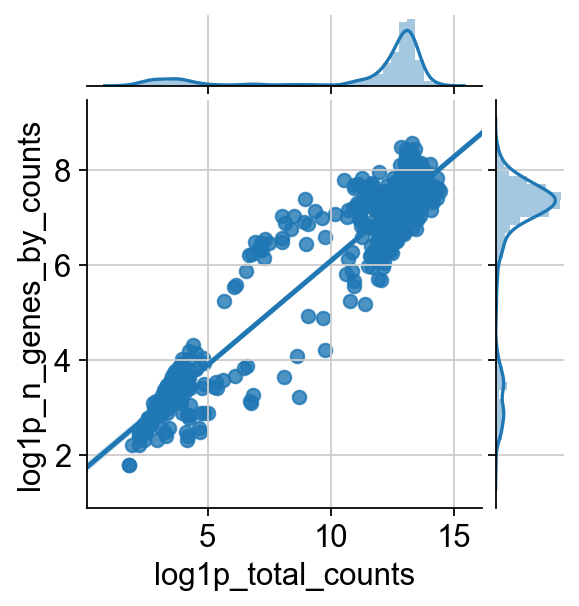

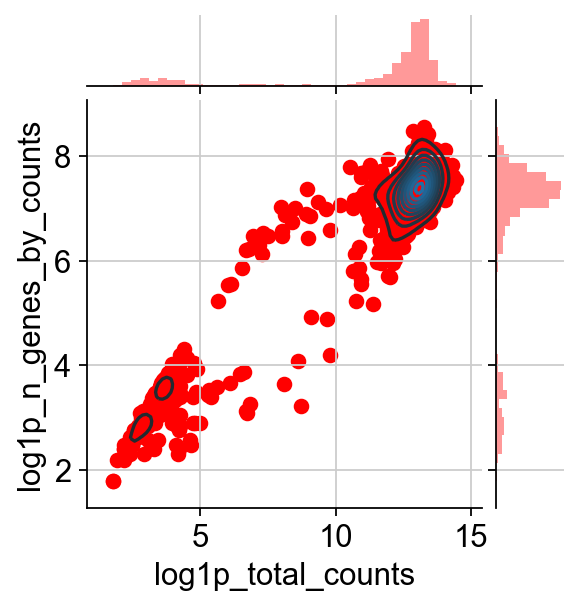

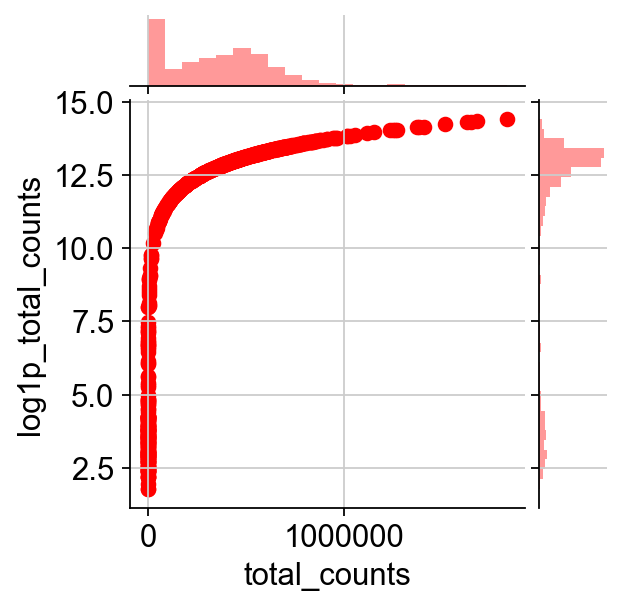

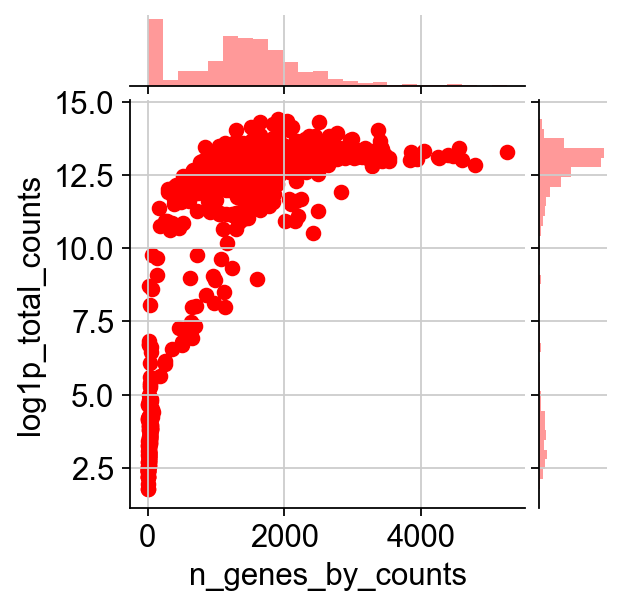

In [339]:
# Quality control metrics. If inplace = True, the output QC variables are added to adata.obs. If inplace = False,
# not included, only calculated and print.
sc.pp.calculate_qc_metrics(adata_Dx_Rx,inplace=True,percent_top=[50])
# Output
# n_genes_by_counts = Number of genes expressed
# log1p_n_genes_by_counts = (logX + 1)
# total_counts = Sum of counts for a gene
# pct_counts_in_top_50_genes = cumulative percentage of counts for 50 most most expressed genes. If deprecated, it 
# will estimate for a range of top genes.

#print(adata.obs)
sns.jointplot("log1p_total_counts","log1p_n_genes_by_counts",
            data=adata_Dx_Rx.obs,kind="reg",height=4)
sns.jointplot("log1p_total_counts","log1p_n_genes_by_counts",
            data=adata_Dx_Rx.obs,color="red",height=4).plot_joint(sns.kdeplot)
sns.jointplot("total_counts","log1p_total_counts",
            data=adata_Dx_Rx.obs,color="red",height=4)
sns.jointplot("n_genes_by_counts","log1p_total_counts",
            data=adata_Dx_Rx.obs,color="red",height=4)
adata_Dx_Rx

In [340]:
# Basic filtering
# Filtering cells and genes
# Cells with at least 2500 genes expressed
print(adata_Dx_Rx.n_obs)
sc.pp.filter_cells(adata_Dx_Rx,min_genes=500)
# or alternatively:
#adata = adata[adata.obs['n_genes'] > 2500, :]
#print(adata.n_obs)
# In case we want to discard genes expressed in less than a minimum number of cells. In our case, only discard genes not expressed at all
sc.pp.filter_genes(adata_Dx_Rx,min_cells=3)
#Filter genes with a maximum number of counts
sc.pp.filter_cells(adata_Dx_Rx,min_counts=20000)
print(adata_Dx_Rx.n_obs)

864
filtered out 170 cells that haveless than 500 genes expressed


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


filtered out 40567 genes that are detectedin less than 3 cells


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


filtered out 20 cells that haveless than 20000 counts


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


674


In [341]:
adata_Dx_Rx.var_names_make_unique

<bound method AnnData.var_names_make_unique of AnnData object with n_obs × n_vars = 674 × 16366 
    obs: 'cell_type', 'time', 'time_cell', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'n_genes', 'n_counts'
    var: 'gene_ids', 'gene_symbols', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'>

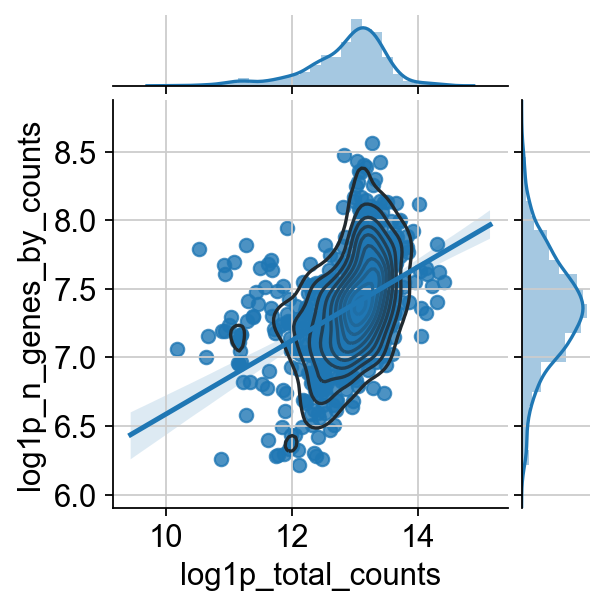

In [342]:
sns.jointplot("log1p_total_counts","log1p_n_genes_by_counts",
            data=adata_Dx_Rx.obs,kind="reg",height=4).plot_joint(sns.kdeplot)

:Scatter   [log1p_total_counts]   (log1p_n_genes_by_counts)

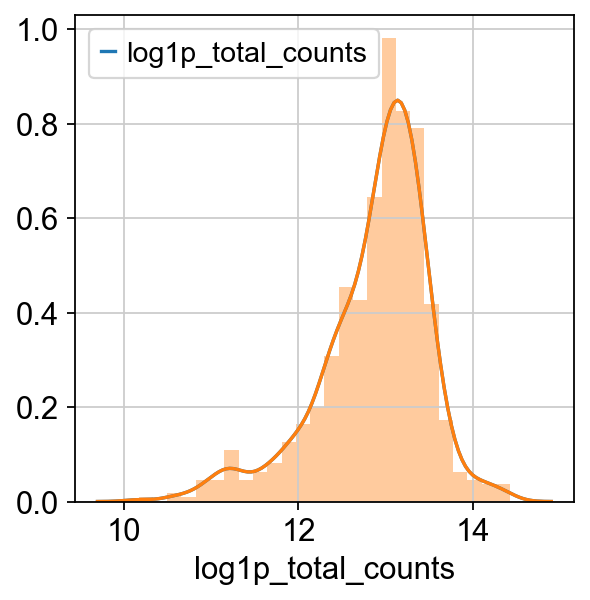

In [343]:
# Python histogram of gene expression levels
sns.kdeplot(adata_Dx_Rx.obs["log1p_total_counts"])
sns.distplot(adata_Dx_Rx.obs["log1p_total_counts"])
#adata.obs.hvplot.hexbin("log1p_total_counts", "log1p_n_genes_by_counts")
adata_Dx_Rx.obs.hvplot.hist("log1p_total_counts")
adata_Dx_Rx.obs.hvplot.hexbin("log1p_total_counts", "log1p_n_genes_by_counts")
adata_Dx_Rx.obs.hvplot.scatter(
    "log1p_total_counts",
    "log1p_n_genes_by_counts",
    dynspread=True
)

### Quality control for mitochondrial genes
#####  High proportions are indicative of poor-quality cells, possibly because of loss of cytoplasmatic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

In [344]:
adata_Dx_Rx.var

gene_ids   gene_symbols  n_cells_by_counts  \
gene_symbols                                                         
DPM1           ENSG0000000041912           DPM1                161   
SCYL3          ENSG0000000045713          SCYL3                 24   
C1orf112       ENSG0000000046016       C1orf112                 55   
FGR            ENSG0000000093812            FGR                  9   
CFH            ENSG0000000097115            CFH                149   
...                          ...            ...                ...   
RP11-147H23.3   ENSG000002854441  RP11-147H23.3                 18   
RP1-93H18.7     ENSG000002854461    RP1-93H18.7                 85   
RP11-397E7.6    ENSG000002854581   RP11-397E7.6                  9   
RP11-468E2.12   ENSG000002854671  RP11-468E2.12                 31   
RP5-931K24.3    ENSG000002855081   RP5-931K24.3                 64   

               mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
gene_symbols                                                           
DPM1             32.620369           3.515132              81.365741   
SCYL3             2.612257           1.284333              97.222222   
C1orf112          5.152789           1.816905              93.634259   
FGR               1.655093           0.976480              98.958333   
CFH              82.661469           4.426778              82.754630   
...                    ...                ...                    ...   
RP11-147H23.3     4.372859           1.681360              97.916667   
RP1-93H18.7       0.003889           0.003881              90.162037   
RP11-397E7.6      0.217847           0.197085              98.958333   
RP11-468E2.12     0.213958           0.193886              96.412037   
RP5-931K24.3      3.685903           1.544559              92.592593   

               total_counts  log1p_total_counts  n_cells  
gene_symbols                                              
DPM1           28184.000000           10.246545      161  
SCYL3           2256.989990            7.722230       24  
C1orf112        4452.009766            8.401336       55  
FGR             1430.000000            7.266129        9  
CFH            71419.507812           11.176340      146  
...                     ...                 ...      ...  
RP11-147H23.3   3778.150146            8.237254       18  
RP1-93H18.7        3.360000            1.472472       84  
RP11-397E7.6     188.220001            5.242910        9  
RP11-468E2.12    184.860001            5.224994       31  
RP5-931K24.3    3184.619873            8.066402       63  

[16366 rows x 9 columns]

In [345]:
# Only if gene symbols!
# In mice mitochondrial are mt- in human MT- or Mt, check!
mito_genes = adata_Dx_Rx.var_names.str.startswith('MT-')
#adata[:,mito_genes].var_names



# Similarly for ribosomal genes
#ribo_genes = adata.var_names.str.startswith('RP')
#adata[:,ribo_genes].var_names

# for each cell compute fraction of counts in mito genes vs. all genes
# the '.A1' is only necessary as X is sparse (to transform to a dense array after summing)

#axis=1 means accross columns
adata_Dx_Rx.obs['percent_mito'] = np.sum(adata_Dx_Rx[:,mito_genes].X, axis=1) / np.sum(adata_Dx_Rx.X, axis=1)
#adata.obs['percent_ribo'] = np.sum(adata[:,ribo_genes].X, axis=1) / np.sum(adata.X, axis=1)


# add the total counts per cell as observations-annotation to adata after filtering steps
adata_Dx_Rx.obs['n_counts'] = adata_Dx_Rx.X.sum(axis=1)



In [346]:
mito_genes

array([False, False, False, ..., False, False, False])

... storing 'cell_type' as categorical
... storing 'time' as categorical
... storing 'time_cell' as categorical
... storing 'gene_symbols' as categorical


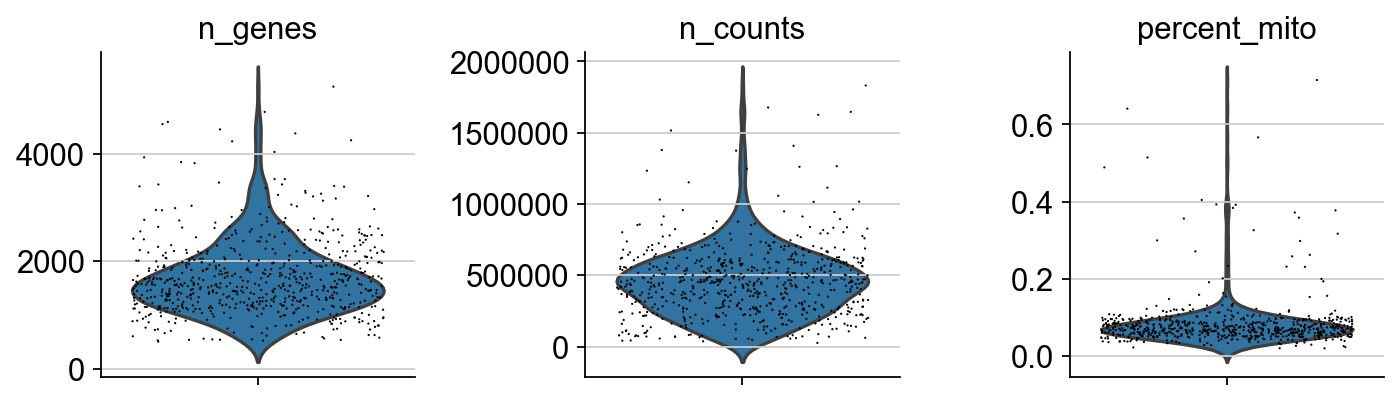

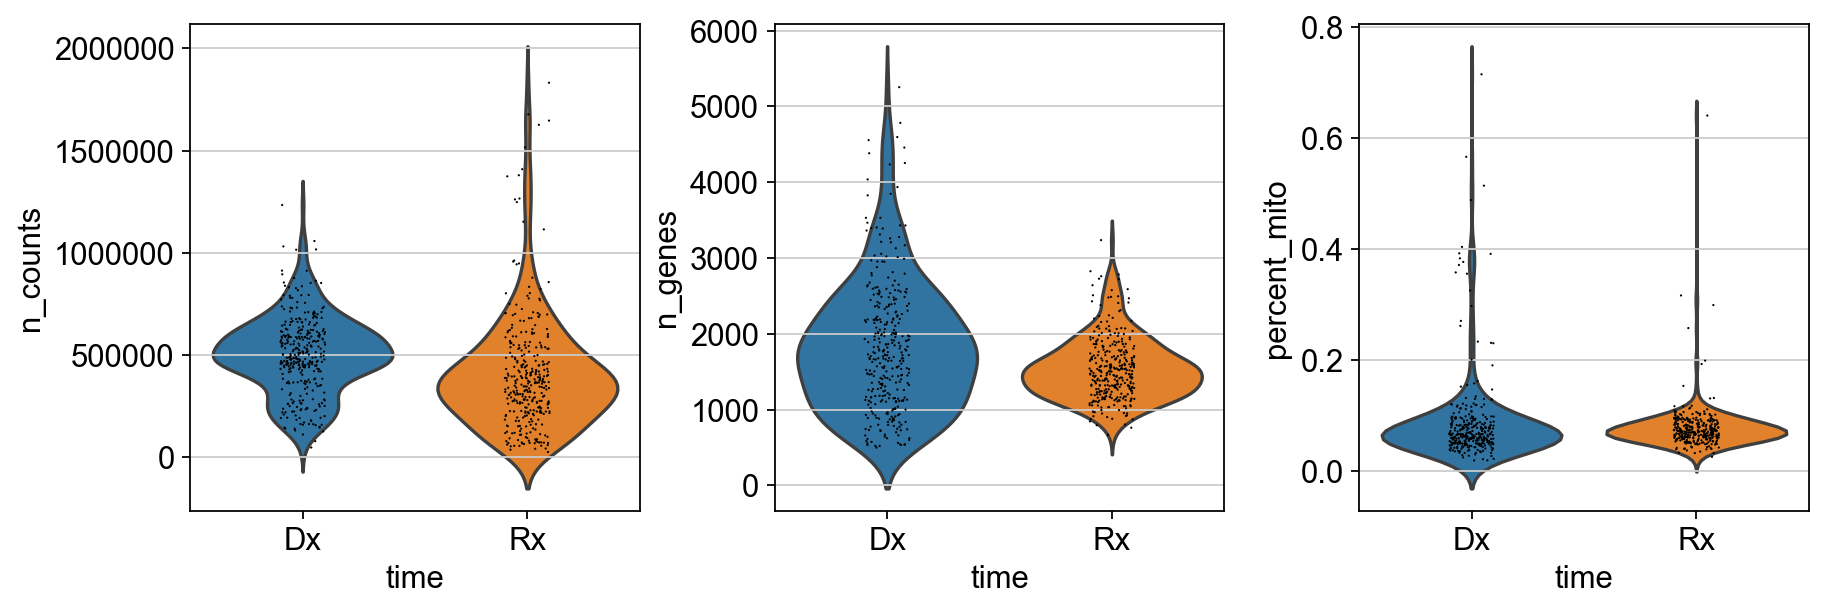

In [347]:
# A violin plot of the computed quality measures
# Plot in the same panel
#sc.pl.violin(adata,['n_genes','n_counts','percent_mito'],
#            jitter=0.4,multi_panel=False)

# Plot in different panel (as facet in R)
sc.pl.violin(adata_Dx_Rx,['n_genes','n_counts','percent_mito'],
            jitter=0.4,multi_panel=True)

#n_counts and genes by Phase
sc.pl.violin(adata_Dx_Rx, ['n_counts','n_genes','percent_mito'], groupby='time')

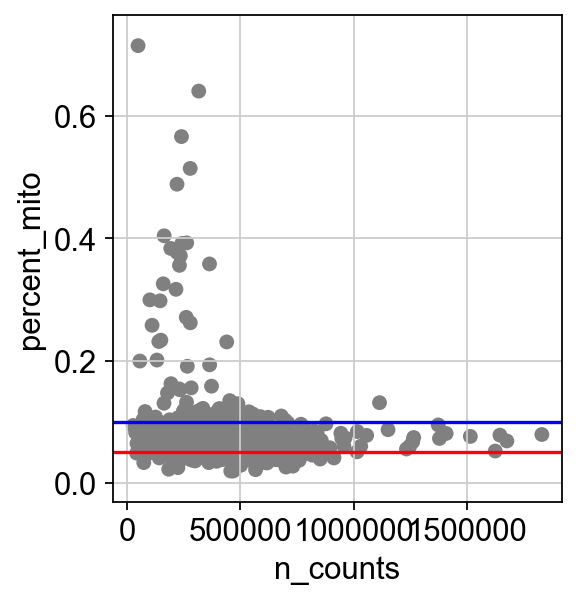

In [348]:
ax = sc.pl.scatter(adata_Dx_Rx, x='n_counts', y='percent_mito', show=False)
ax.axhline(y=0.05, c='red')
ax.axhline(y=0.1, c='blue')

In [349]:
# Remove cells that have too many mitochondrial genes expressed or too many total counts
#sc.pl.scatter(adata, x='n_counts', y='percent_mito')
#sc.pl.scatter(adata, x='n_counts',y='n_genes')
#adata

# Keep cells with less than 20% mithochondrial genes expressed.
print(adata_Dx_Rx)
adata_Dx_Rx[adata_Dx_Rx.obs['percent_mito'] < 0.20, :]


AnnData object with n_obs × n_vars = 674 × 16366 
    obs: 'cell_type', 'time', 'time_cell', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'n_genes', 'n_counts', 'percent_mito'
    var: 'gene_ids', 'gene_symbols', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'


View of AnnData object with n_obs × n_vars = 650 × 16366 
    obs: 'cell_type', 'time', 'time_cell', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'n_genes', 'n_counts', 'percent_mito'
    var: 'gene_ids', 'gene_symbols', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

#### TOTAL FILTERED CELLS = 650 

In [350]:
# Normalization by scanpy. The sum of all counts will be 1000. See manual for other parameters.
#print(adata.X)
sc.pp.normalize_total(adata_Dx_Rx, target_sum=1e4)

# And now, logarithmize the data
sc.pp.log1p(adata_Dx_Rx)

Normalizing counts per cell.
    finished (0:00:00):normalized adata.X


In [351]:
# Now set the .raw attribute of adata to the logarithmized raw gene expresseion for later use. This freezes the state
# of adata object.
# adata.raw -- Store raw version of X and var as .raw.X and .raw.var.
# Its content can be deleted by setting it back to None: adata.raw = None
# To retrieve the data associated with a variable that might have been filtered out or "compressed away" in X:
# adata.raw[:, 'orig_variable_name'].X
adata_Dx_Rx.raw = adata_Dx_Rx

/Users/yolanda_guillen/miniconda3/lib/python3.7/site-packages/anndata/core/anndata.py:299: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


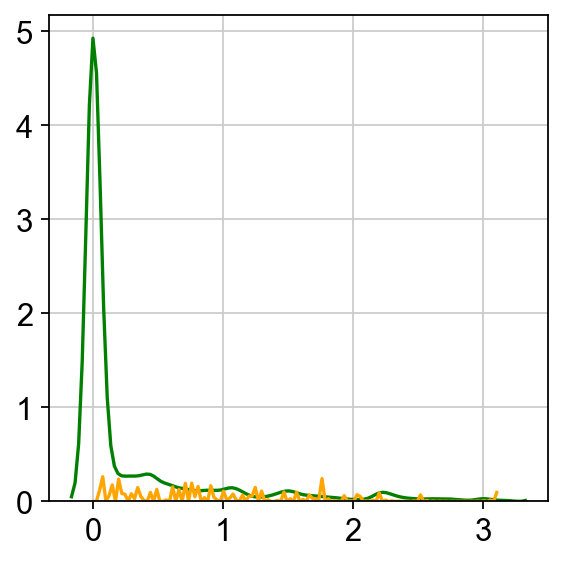

In [352]:
# Check the distribution of some genes in all samples to compare highly expressed genes.
gene0 = adata_Dx_Rx.raw[:, 'CTNNB1'].X
gene2 = adata_Dx_Rx.raw[:, 'CDK12'].X
sns.kdeplot(gene0,color="green")
sns.kdeplot(gene2,color="orange")


### Identify highly-variable genes

In [353]:
# Expects logarithmized data.
# The normalized dispersion is obtained by scaling with the mean and standard deviation of the
# dispersions for genes falling into a given bin for mean expression of genes. This means that
# for each bin of mean expression, highly variable genes are selected.

# values by default
sc.pp.highly_variable_genes(adata_Dx_Rx,
                            min_mean = 0.0125,
                           max_mean = 3,
                           min_disp= 0.5)
# from this point, if we want to plot gene counts distribution, we need to use adata.raw X matrix

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


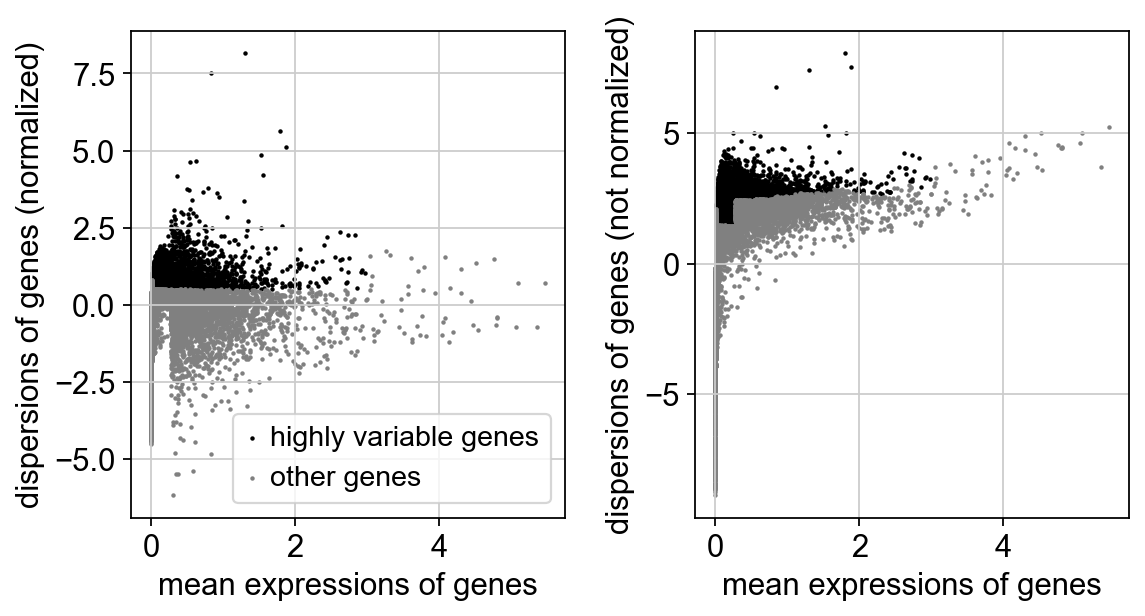

In [354]:
# Plot
sc.pl.highly_variable_genes(adata_Dx_Rx)

#### Top expressed genes: Ribosomal (they shouldn't be there since only polyA RNA was isolated) and mitochondrial genes (mt-) which means that cells were injured during isolation/treatment/experiment

In [355]:
adata_Dx_Rx.var

gene_ids   gene_symbols  n_cells_by_counts  \
gene_symbols                                                         
DPM1           ENSG0000000041912           DPM1                161   
SCYL3          ENSG0000000045713          SCYL3                 24   
C1orf112       ENSG0000000046016       C1orf112                 55   
FGR            ENSG0000000093812            FGR                  9   
CFH            ENSG0000000097115            CFH                149   
...                          ...            ...                ...   
RP11-147H23.3   ENSG000002854441  RP11-147H23.3                 18   
RP1-93H18.7     ENSG000002854461    RP1-93H18.7                 85   
RP11-397E7.6    ENSG000002854581   RP11-397E7.6                  9   
RP11-468E2.12   ENSG000002854671  RP11-468E2.12                 31   
RP5-931K24.3    ENSG000002855081   RP5-931K24.3                 64   

               mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
gene_symbols                                                           
DPM1             32.620369           3.515132              81.365741   
SCYL3             2.612257           1.284333              97.222222   
C1orf112          5.152789           1.816905              93.634259   
FGR               1.655093           0.976480              98.958333   
CFH              82.661469           4.426778              82.754630   
...                    ...                ...                    ...   
RP11-147H23.3     4.372859           1.681360              97.916667   
RP1-93H18.7       0.003889           0.003881              90.162037   
RP11-397E7.6      0.217847           0.197085              98.958333   
RP11-468E2.12     0.213958           0.193886              96.412037   
RP5-931K24.3      3.685903           1.544559              92.592593   

               total_counts  log1p_total_counts  n_cells  highly_variable  \
gene_symbols                                                                
DPM1           28184.000000           10.246545      161            False   
SCYL3           2256.989990            7.722230       24             True   
C1orf112        4452.009766            8.401336       55             True   
FGR             1430.000000            7.266129        9             True   
CFH            71419.507812           11.176340      146             True   
...                     ...                 ...      ...              ...   
RP11-147H23.3   3778.150146            8.237254       18             True   
RP1-93H18.7        3.360000            1.472472       84            False   
RP11-397E7.6     188.220001            5.242910        9            False   
RP11-468E2.12    184.860001            5.224994       31            False   
RP5-931K24.3    3184.619873            8.066402       63            False   

                  means  dispersions  dispersions_norm  
gene_symbols                                            
DPM1           0.635858     1.620225         -0.998910  
SCYL3          0.075912     2.038723          0.781748  
C1orf112       0.134682     1.775097          0.653179  
FGR            0.050220     2.049079          0.786799  
CFH            1.204421     3.177230          1.264409  
...                 ...          ...               ...  
RP11-147H23.3  0.120226     2.683779          1.096339  
RP1-93H18.7    0.000090    -4.079018         -2.201847  
RP11-397E7.6   0.004604    -0.552780         -0.482117  
RP11-468E2.12  0.005133     0.140041         -0.144231  
RP5-931K24.3   0.107041     0.598442          0.079330  

[16366 rows x 13 columns]

In [356]:

# highly_variable is now a boolean variable (adata.var) indicating whether a gene is considered highly variable (True),
# or not (False)


# Selecting only highly_variable genes
adata_Dx_Rx = adata_Dx_Rx[:, adata_Dx_Rx.var['highly_variable']]
adata_Dx_Rx.var

# Check that now all values of highly_variable are True

gene_ids   gene_symbols  n_cells_by_counts  \
gene_symbols                                                         
SCYL3          ENSG0000000045713          SCYL3                 24   
C1orf112       ENSG0000000046016       C1orf112                 55   
FGR            ENSG0000000093812            FGR                  9   
CFH            ENSG0000000097115            CFH                149   
NFYA           ENSG0000000116714           NFYA                 35   
...                          ...            ...                ...   
ARHGAP11B       ENSG000002850771      ARHGAP11B                 33   
RP5-1091N2.12   ENSG000002851711  RP5-1091N2.12                127   
TFAP2A-AS2      ENSG000002852781     TFAP2A-AS2                  9   
CTD-3110H11.3   ENSG000002854101  CTD-3110H11.3                 31   
RP11-147H23.3   ENSG000002854441  RP11-147H23.3                 18   

               mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
gene_symbols                                                           
SCYL3             2.612257           1.284333              97.222222   
C1orf112          5.152789           1.816905              93.634259   
FGR               1.655093           0.976480              98.958333   
CFH              82.661469           4.426778              82.754630   
NFYA             13.250000           2.656757              95.949074   
...                    ...                ...                    ...   
ARHGAP11B         2.060023           1.118423              96.180556   
RP5-1091N2.12     4.871621           1.770131              85.300926   
TFAP2A-AS2        0.954363           0.670065              98.958333   
CTD-3110H11.3     6.086805           1.958235              96.412037   
RP11-147H23.3     4.372859           1.681360              97.916667   

               total_counts  log1p_total_counts  n_cells  highly_variable  \
gene_symbols                                                                
SCYL3           2256.989990            7.722230       24             True   
C1orf112        4452.009766            8.401336       55             True   
FGR             1430.000000            7.266129        9             True   
CFH            71419.507812           11.176340      146             True   
NFYA           11448.000000            9.345657       35             True   
...                     ...                 ...      ...              ...   
ARHGAP11B       1779.859985            7.484852       33             True   
RP5-1091N2.12   4209.080078            8.345237      127             True   
TFAP2A-AS2       824.570007            6.716074        9             True   
CTD-3110H11.3   5259.000000            8.567886       31             True   
RP11-147H23.3   3778.150146            8.237254       18             True   

                  means  dispersions  dispersions_norm  
gene_symbols                                            
SCYL3          0.075912     2.038723          0.781748  
C1orf112       0.134682     1.775097          0.653179  
FGR            0.050220     2.049079          0.786799  
CFH            1.204421     3.177230          1.264409  
NFYA           0.297729     2.494140          0.599422  
...                 ...          ...               ...  
ARHGAP11B      0.092907     3.096171          1.297461  
RP5-1091N2.12  0.138455     1.691381          0.612351  
TFAP2A-AS2     0.024843     1.513713          0.525703  
CTD-3110H11.3  0.138860     2.222606          0.871427  
RP11-147H23.3  0.120226     2.683779          1.096339  

[5797 rows x 13 columns]

In [357]:
print(adata_Dx_Rx)
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Also regress out for
# cell cycle numerical scores 
sc.pp.regress_out(adata_Dx_Rx, ['n_counts','percent_mito'])
# no cell cycle regress
#sc.pp.regress_out(adata, ['n_counts','percent_mito'])

View of AnnData object with n_obs × n_vars = 674 × 5797 
    obs: 'cell_type', 'time', 'time_cell', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'n_genes', 'n_counts', 'percent_mito'
    var: 'gene_ids', 'gene_symbols', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
regressing out ['n_counts', 'percent_mito']
    finished (0:00:14)


In [358]:
adata_Dx_Rx.obs_keys

<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 674 × 5797 
    obs: 'cell_type', 'time', 'time_cell', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'n_genes', 'n_counts', 'percent_mito'
    var: 'gene_ids', 'gene_symbols', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'>

In [359]:
# Now scale each gene to unit variance. Clip values exceeding standard deviation 10
sc.pp.scale(adata_Dx_Rx, max_value = 10)

normalizing by total count per cell
filtered out 438 cells that haveless than 1 counts
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


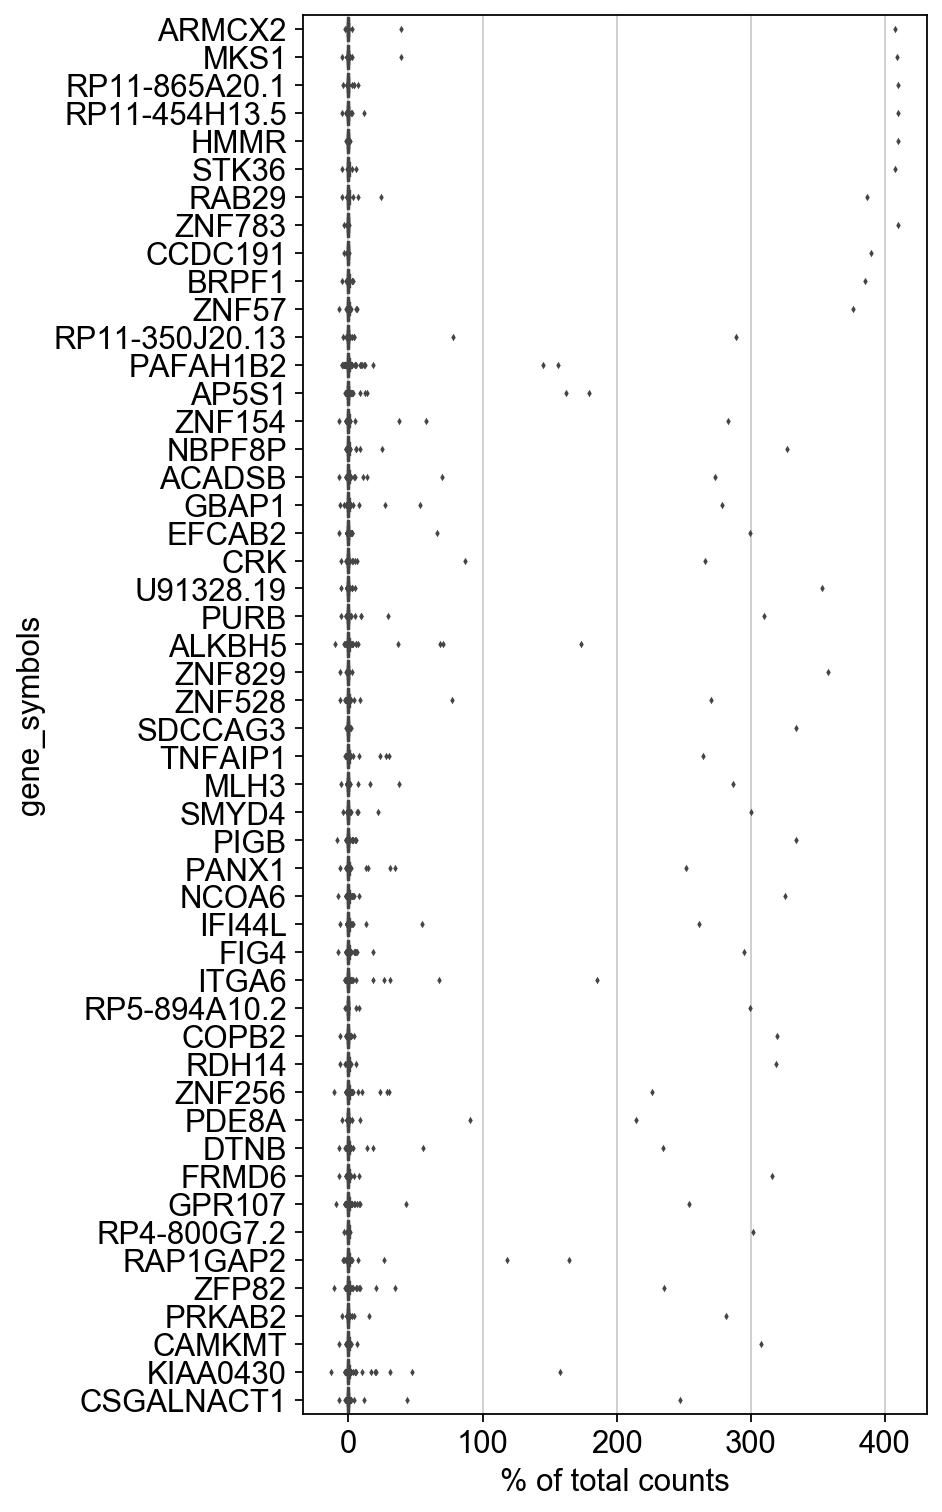

In [360]:
sc.pl.highest_expr_genes(adata_Dx_Rx, n_top=50)

## VISUALIZATION 

### Simplest multidimensional representation = PCA
#### Clusters will be infered later using UMAP from PCs in PCA

In [361]:


# tl is for tools, pp was for preprocessing
sc.tl.pca(adata_Dx_Rx)



Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)


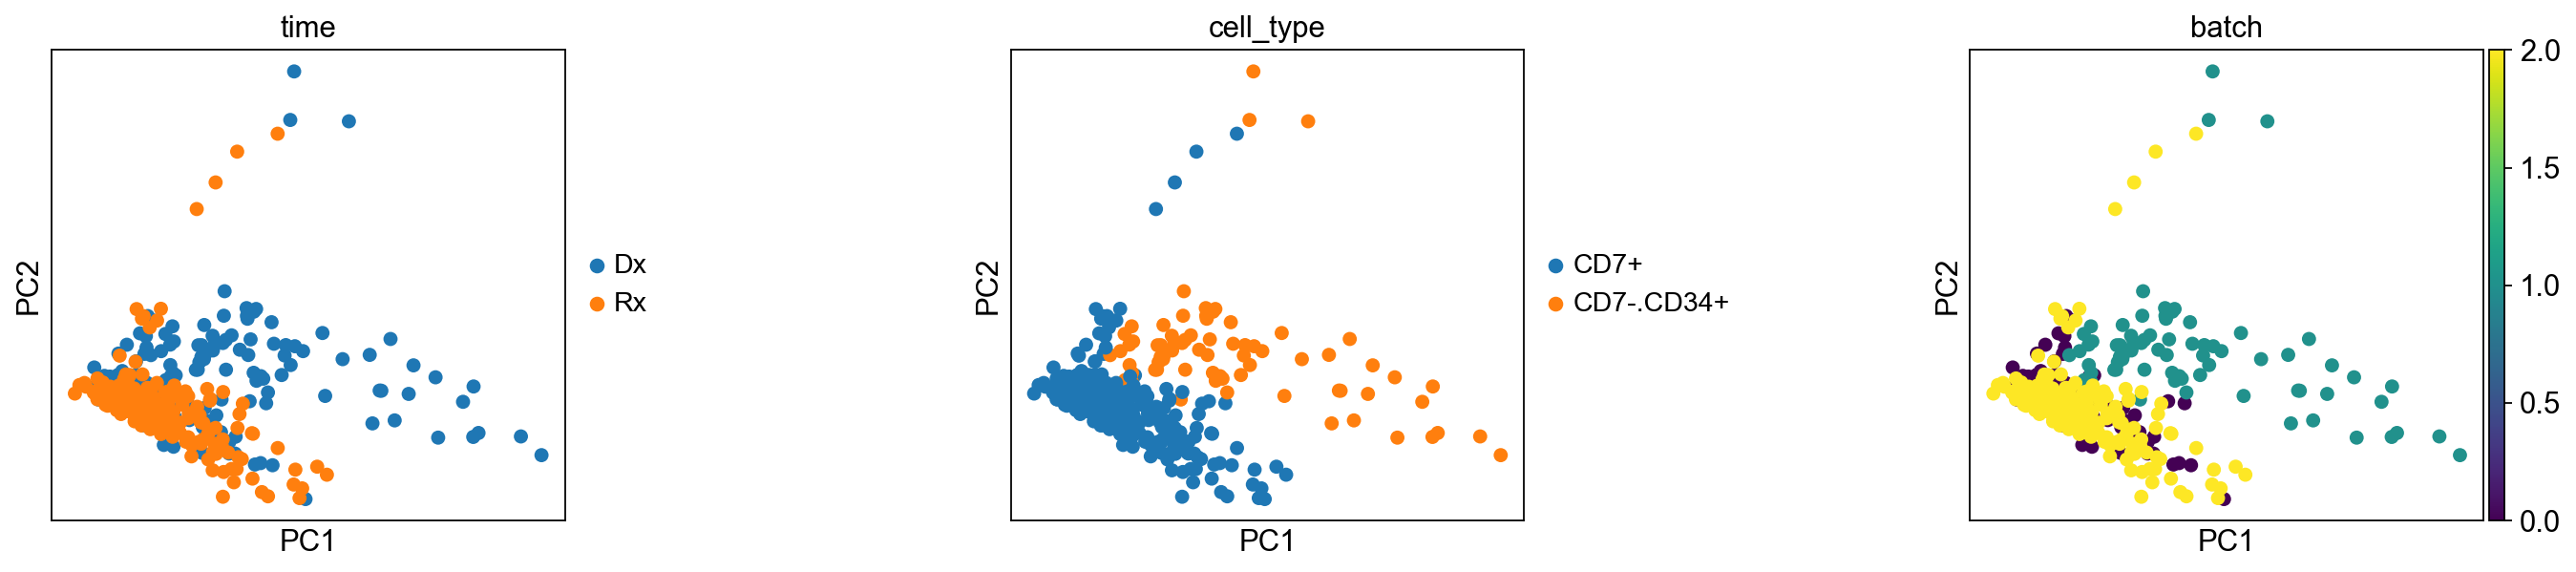

In [362]:
sc.pl.pca_scatter(adata_Dx_Rx, color=['time','cell_type','batch'], wspace=0.7)

##### Color by marker protein and its corresponding gene

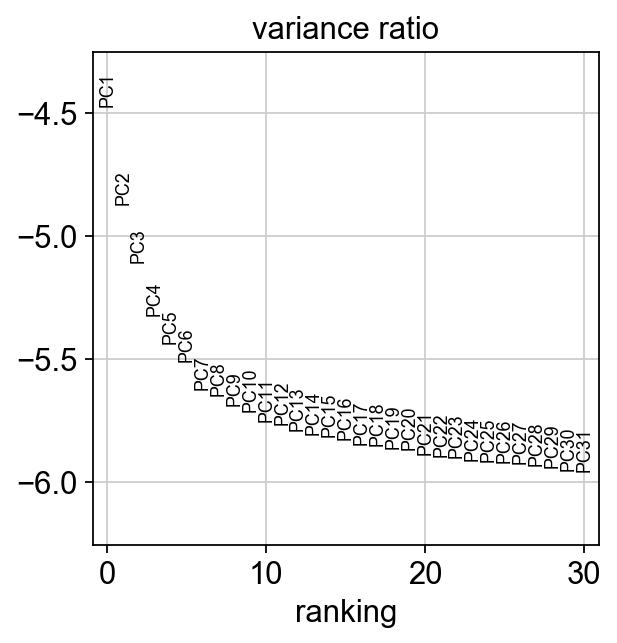

In [363]:
# Estimation of the contribution of single PCs to the total variance in the data. This gives us information
# about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in
# the clustering function sc.tl.louvain() or tSNE sc.tl.tsne. In our experience, often, a rough estmiate of the
# number of PCs does fine.
sc.pl.pca_variance_ratio(adata_Dx_Rx, log=True)


In [365]:

# Save the result
# Results wil be saved in scRNA_AGM.h5ad (previously defined)
adata_Dx_Rx.write(results_file)

In [366]:
adata_Dx_Rx

AnnData object with n_obs × n_vars = 674 × 5797 
    obs: 'cell_type', 'time', 'time_cell', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'n_genes', 'n_counts', 'percent_mito'
    var: 'gene_ids', 'gene_symbols', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'time_colors', 'cell_type_colors'
    obsm: 'X_pca'
    varm: 'PCs'

### UMAP Computation

In [396]:
## Computing the neighborhood graph

# Let us compute the neighborhood graph of cells using the PCA representation of the data matrix.
# You might simply use default values here. For the sake of reproducing Seurat's results, let's take
# the following values.

sc.pp.neighbors(adata_Dx_Rx, n_neighbors = 5)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)


In [397]:
sc.tl.umap(adata_Dx_Rx,n_components=2)

computing UMAP
    finished (0:00:00)


In [398]:
adata_Dx_Rx.obsm['X_umap'].shape

(674, 2)

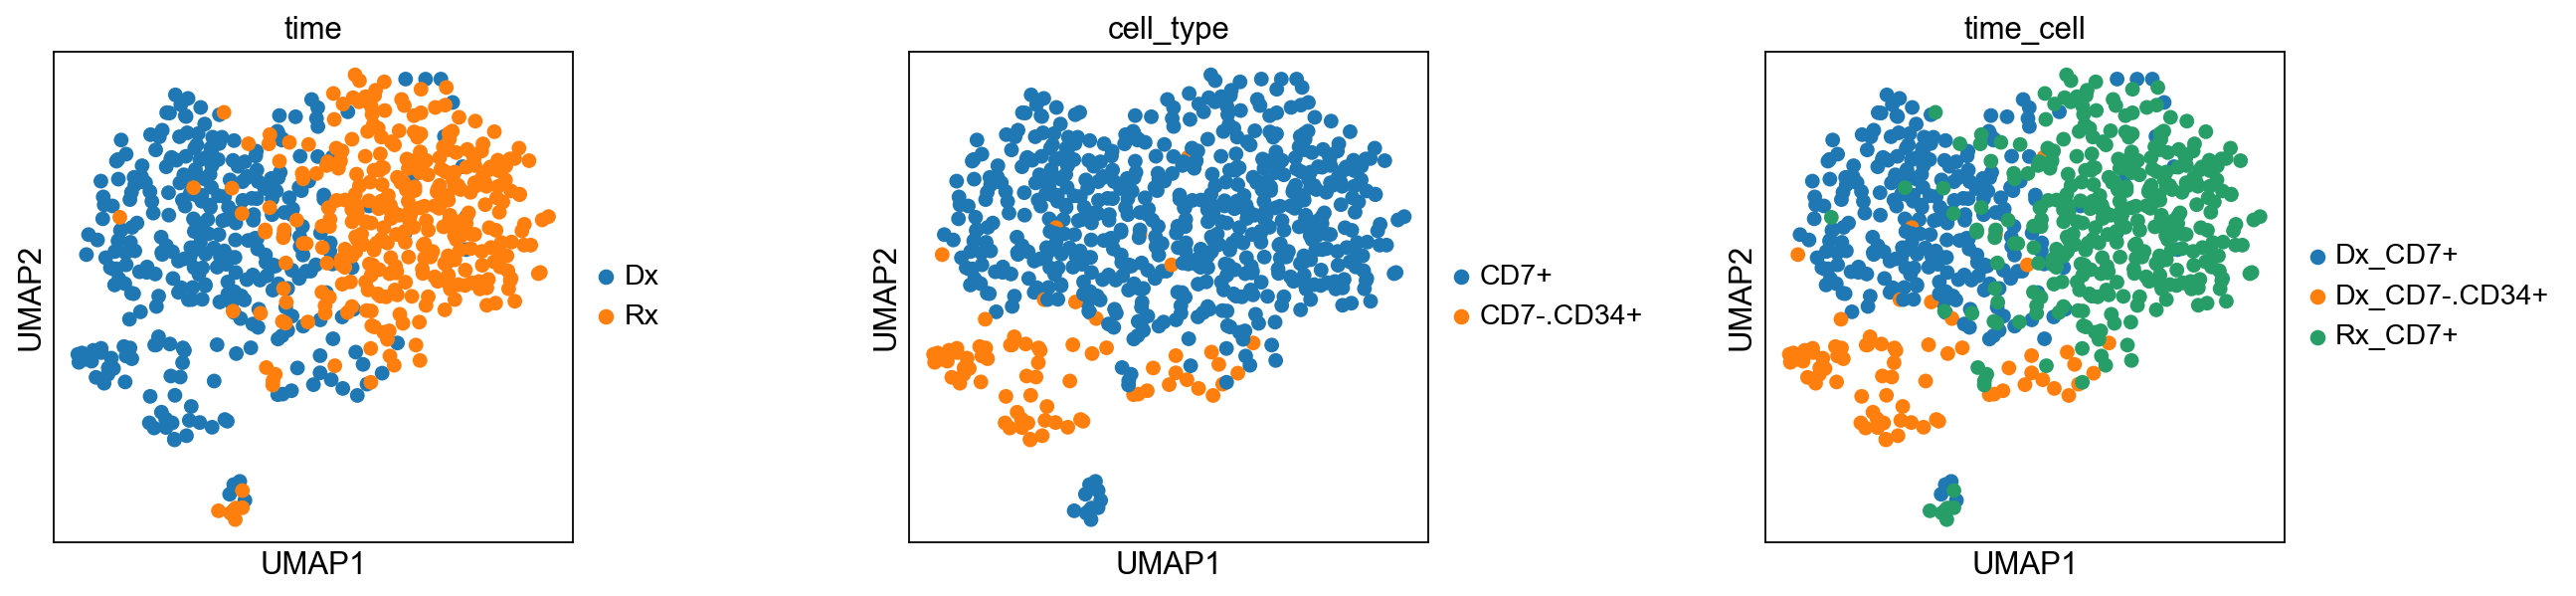

In [399]:
sc.pl.umap(adata_Dx_Rx, color=['time', 'cell_type','time_cell'],use_raw=False, wspace=0.5, components=[1,2])

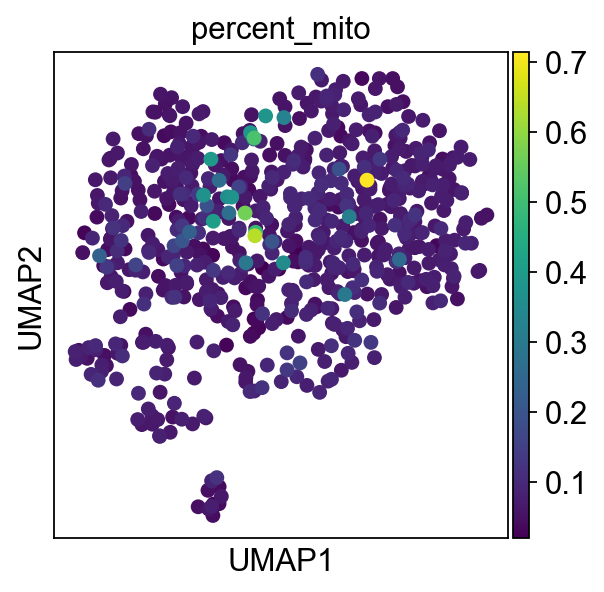

In [400]:
sc.pl.umap(adata_Dx_Rx, color=['percent_mito'],use_raw=False, wspace=0.5)

#### CLUSTERING THE NEIGHBORHOOD GRAPHS

In [406]:

# As Seurat and many others, we recommend the Louvain graph-clustering method (community detection based method based
# on optimazing modularity). It has been proposed for single-cell data by Levite et al. 2015. Louvain clustering
# directly clusters the neighborhood graph of cells, which we already computed in the previous section

# With louvain we identify different clusters based on UMAP
# Reducing resolution, we reduce the number of different clusters
sc.tl.louvain(adata_Dx_Rx, resolution = 0.5, random_state=0)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


In [407]:
rawadata=adata_Dx_Rx

#### Number of Clusters

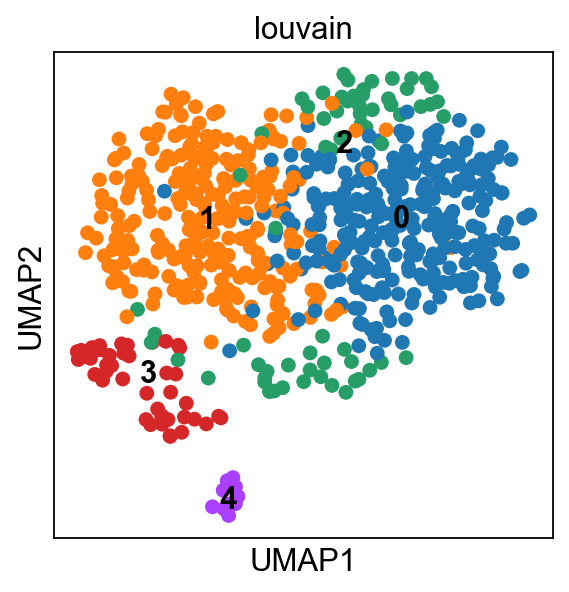

In [408]:
sc.pl.umap(adata_Dx_Rx, color=['louvain'], wspace=0.5, legend_loc='on data')

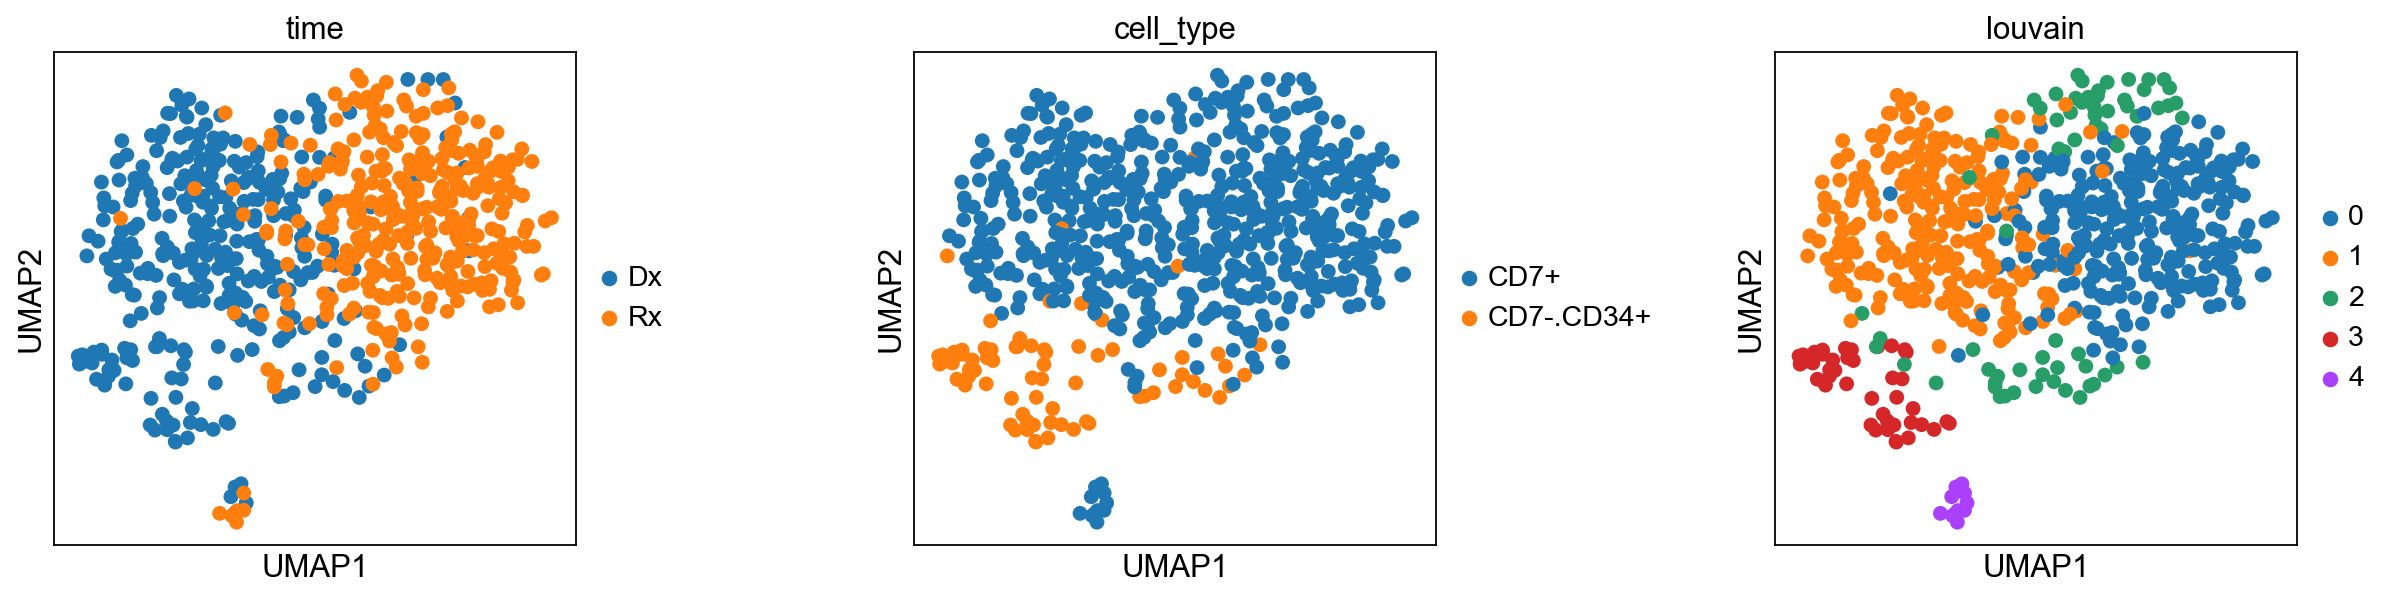

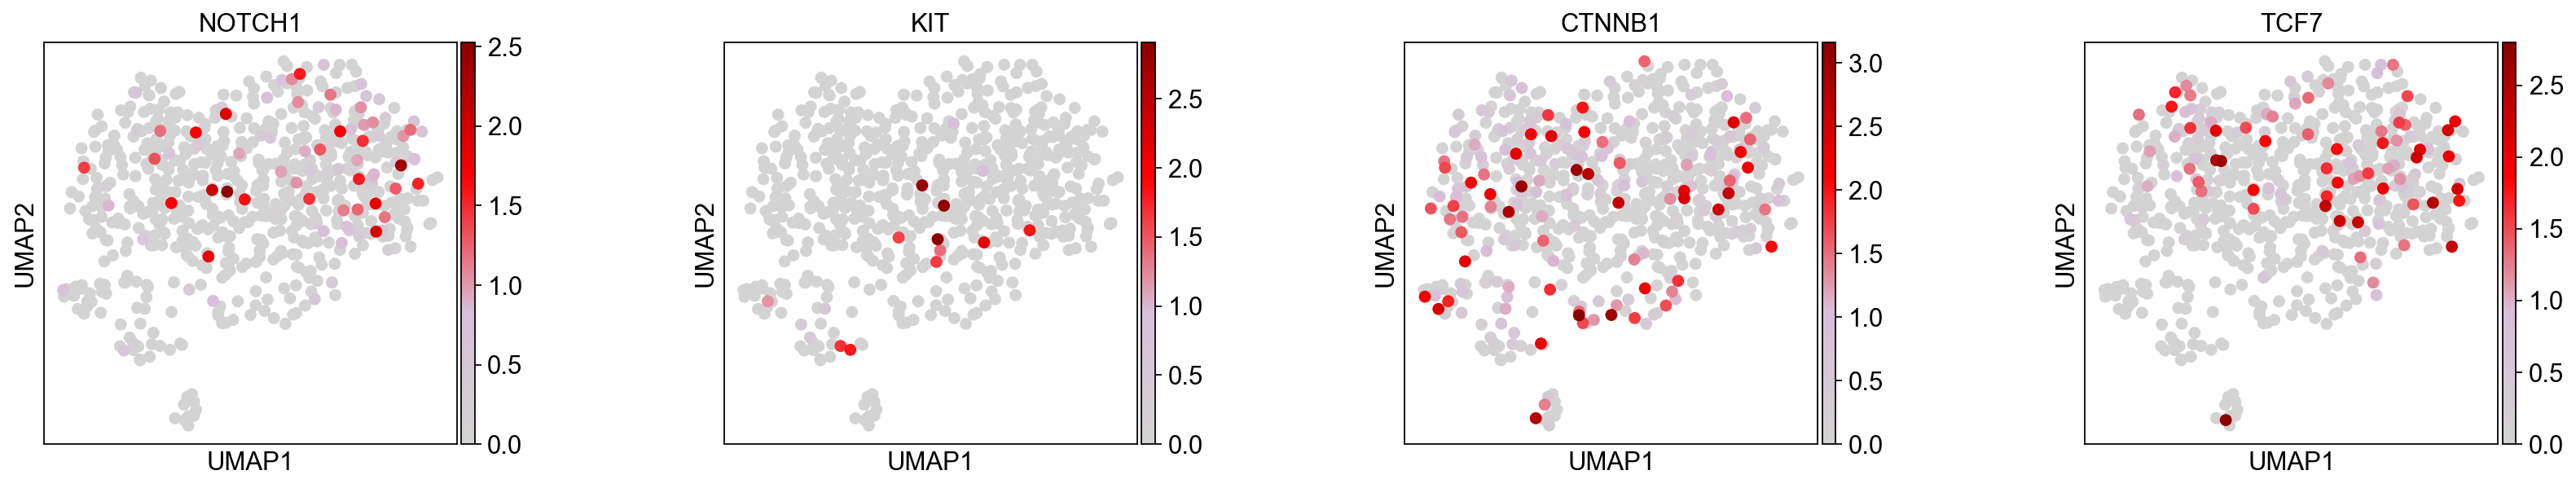

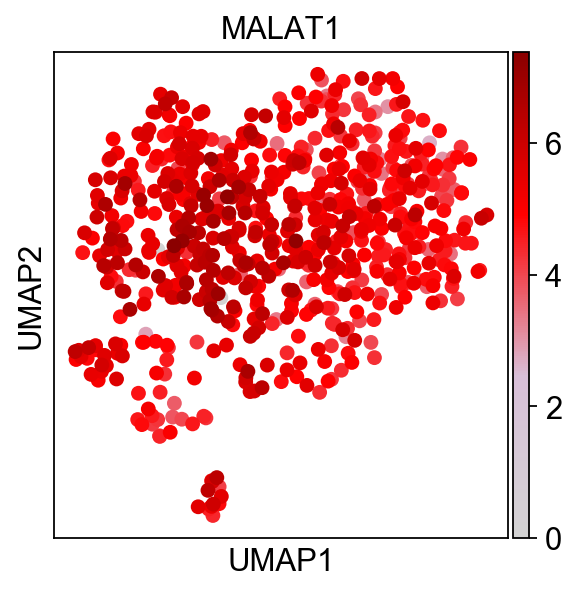

In [418]:
sc.pl.umap(adata_Dx_Rx, color=['time','cell_type','louvain'], wspace=0.5)
sc.pl.umap(adata_Dx_Rx, color=['NOTCH1','KIT','CTNNB1','TCF7'], wspace=0.5,color_map=cmap)
sc.pl.umap(adata_Dx_Rx, color=['MALAT1'], wspace=0.5,color_map=cmap)

In [414]:
# Subset cells by cluster (HE)
k4=adata_Dx_Rx[adata_Dx_Rx.obs['louvain'] ==  '4']
print(k4)

View of AnnData object with n_obs × n_vars = 12 × 5797 
    obs: 'cell_type', 'time', 'time_cell', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'n_genes', 'n_counts', 'percent_mito', 'louvain'
    var: 'gene_ids', 'gene_symbols', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'time_colors', 'cell_type_colors', 'neighbors', 'time_cell_colors', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'


In [415]:
# Rank genes by louvain group
sc.tl.rank_genes_groups(k4,groupby='time')

ranking genes
    finished (0:00:00)


In [416]:
k4.uns_keys()

['cell_type_colors',
 'louvain',
 'louvain_colors',
 'neighbors',
 'pca',
 'rank_genes_groups',
 'time_cell_colors',
 'time_colors']

In [417]:
pd.DataFrame(k4.uns['rank_genes_groups']['names']).head(30)

Dx             Rx
0    RP11-492M23.2  CH507-513H4.4
1     RP11-864I4.1         DNAJA1
2          RPS26P8           AREG
3     RP11-151A6.3           DDX5
4            RPL41  CH507-513H4.3
5     GS1-184P14.2          DDX24
6    RP11-308D13.2         ARID4B
7     RP4-706A16.3          ZFP36
8   RPL17-C18orf32          CNOT2
9            PAIP2          DEGS1
10   RP11-587D21.1          WBP11
11         HNRNPH1        U2AF1L4
12   RP11-349N19.2           LSM7
13   RP11-393I23.2          DDIT4
14           CNOT1  CH507-513H4.6
15          MT-CYB          NR1H2
16        ATP6V1G1           NAPA
17          MT-CO1          HMGN3
18          POLR2C           IER2
19   RP5-857K21.10         TYROBP
20    RP11-311P8.1           CCL5
21          UBE2L3         ZNF292
22          LAPTM5          EIF2D
23           HLA-B           IRF1
24    RP11-88H10.1          RACK1
25     RP11-50D9.1        ZFP36L1
26            RPS6  RP11-349A22.5
27           HLA-A        PTPRCAP
28      AC073610.5         TUBA4A
29          MALAT1            TES

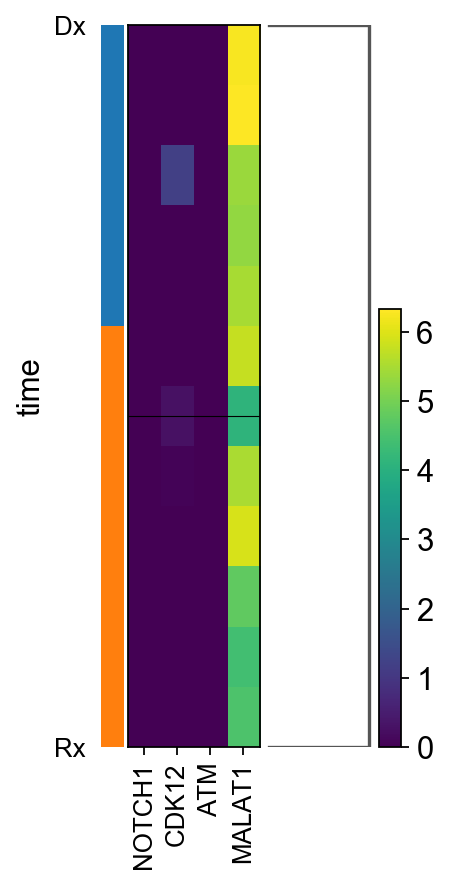

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0.2, 1.2, 1, 0.2])

In [422]:
# Heatmap with selected genes
sc.pl.heatmap(k4,['NOTCH1','CDK12','ATM','MALAT1'],
              groupby='time',
              dendrogram=True,
              swap_axes=False)

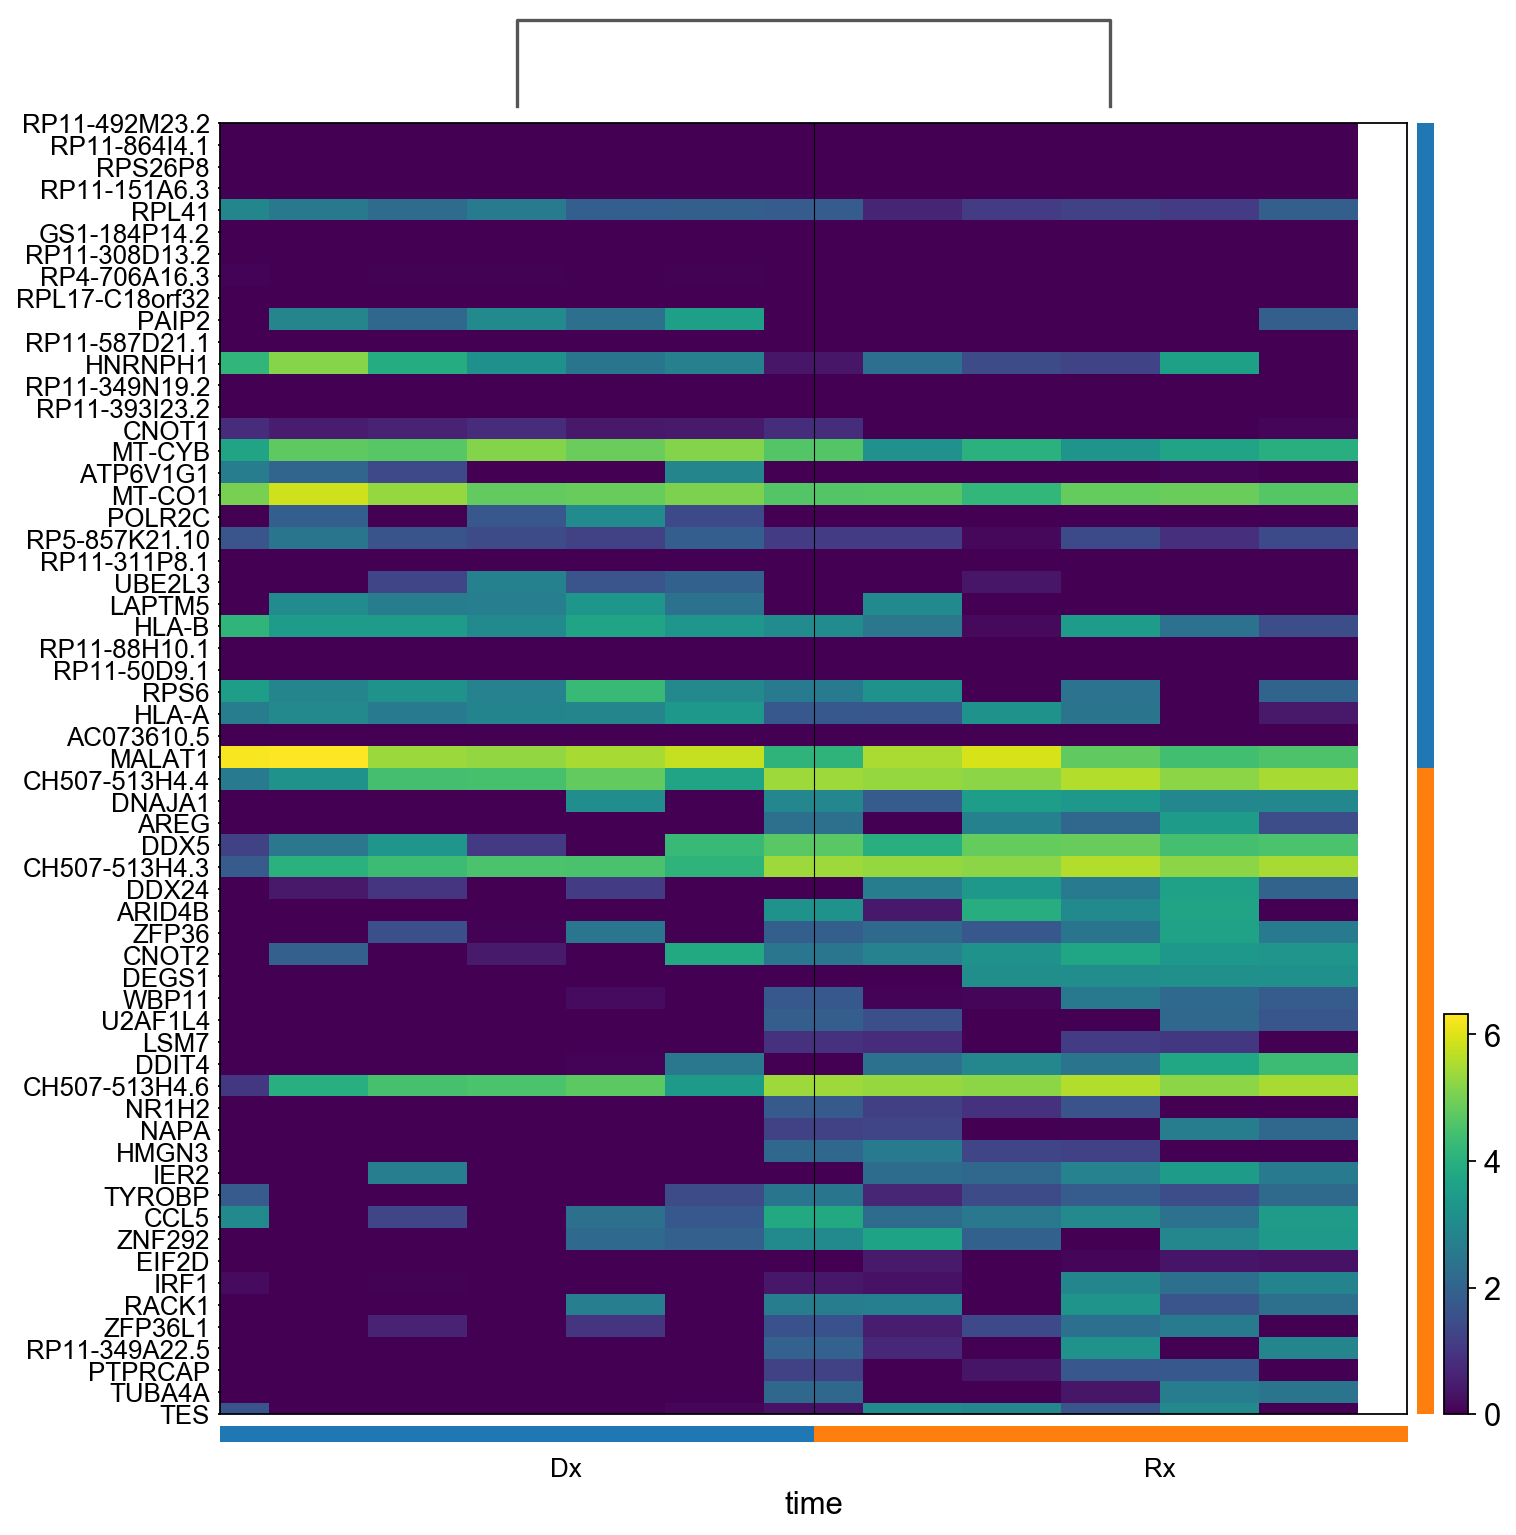

In [424]:
sc.pl.rank_genes_groups_heatmap(k4,
                                n_genes=30,
                                show_gene_labels=True,
                               swap_axes=True)

### Comparing in the clusters the correlation Ab protein marker (upper case) - gene (lower case) 

## Embedding the neighborhood graph -- PAGA

In [425]:
#Compute neighbors, previously they were 5 in adatared
sc.pp.neighbors(adata_Dx_Rx, n_neighbors = 10)


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)


In [426]:
# Recommended use of UMAP (McInnes et al. 2018). More faithful to the global connectivity of the manifold than tSNE, 
# i.e., it better preserves trajectories. In some occasions, you might still observe disconnected clusters and 
# similar connectivity violations. They can usually be remedied by running:

sc.tl.draw_graph(adata_Dx_Rx)
#sc.pl.paga(adata)

drawing single-cell graph using layout 'fa'
    finished (0:00:01)


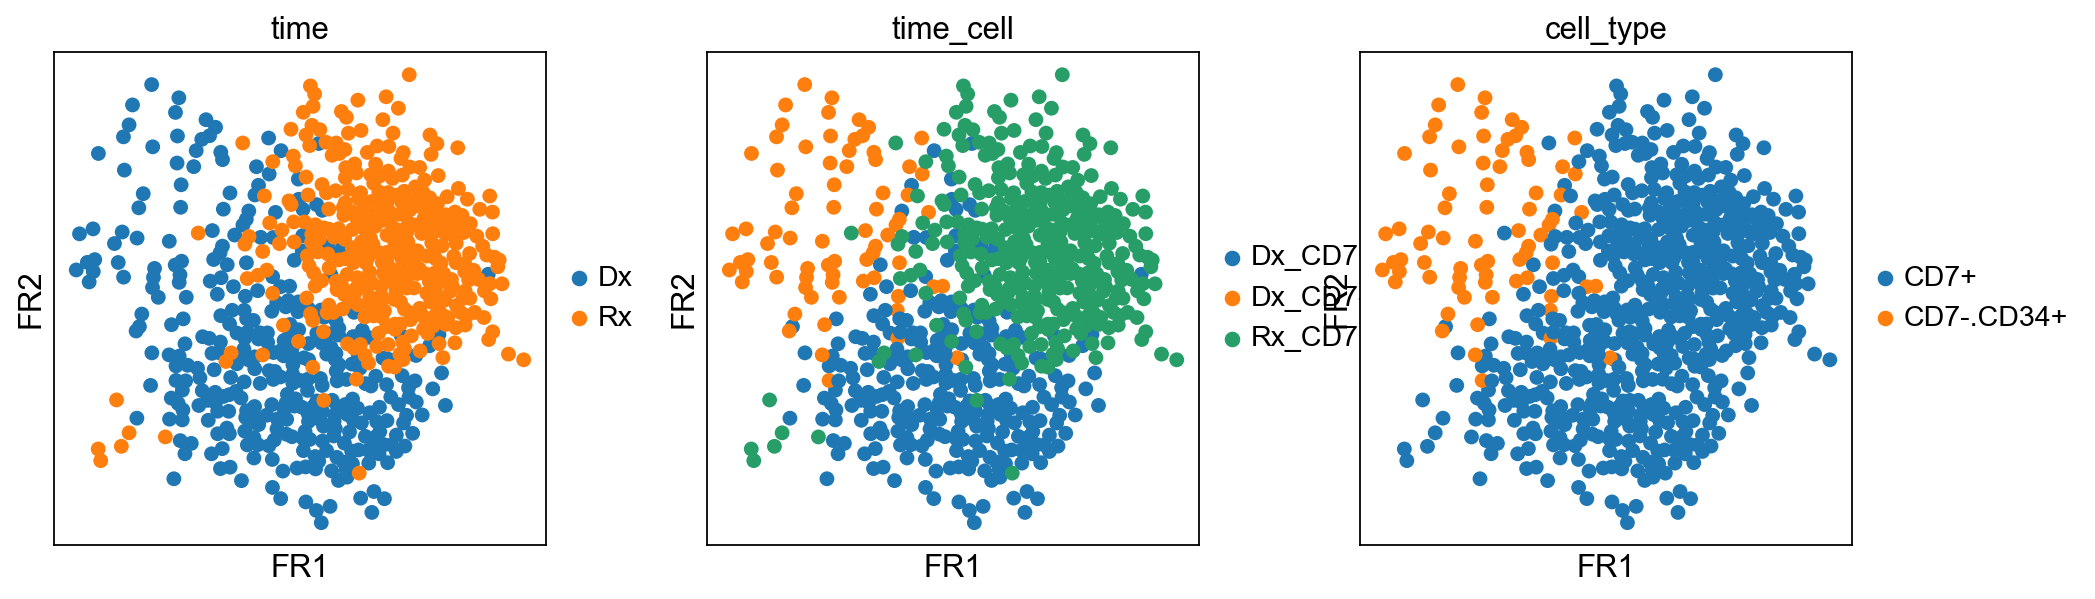

In [427]:
sc.pl.draw_graph(adata_Dx_Rx,color=['time','time_cell','cell_type'])

In [428]:
# DENOISING GRAPH (not in PCA space) correcting with diffmap
sc.tl.diffmap(adata_Dx_Rx)
sc.pp.neighbors(adata_Dx_Rx, n_neighbors=10, use_rep='X_diffmap')

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.94259995 0.90688795 0.8659205  0.8467666  0.8173528
     0.79029244 0.78209126 0.7602935  0.74267536 0.72965854 0.7175338
     0.7083674  0.70608157 0.69745326]
    finished (0:00:00)
computing neighbors
    finished (0:00:00)


In [429]:
sc.tl.draw_graph(adata_Dx_Rx)

drawing single-cell graph using layout 'fa'
    finished (0:00:01)


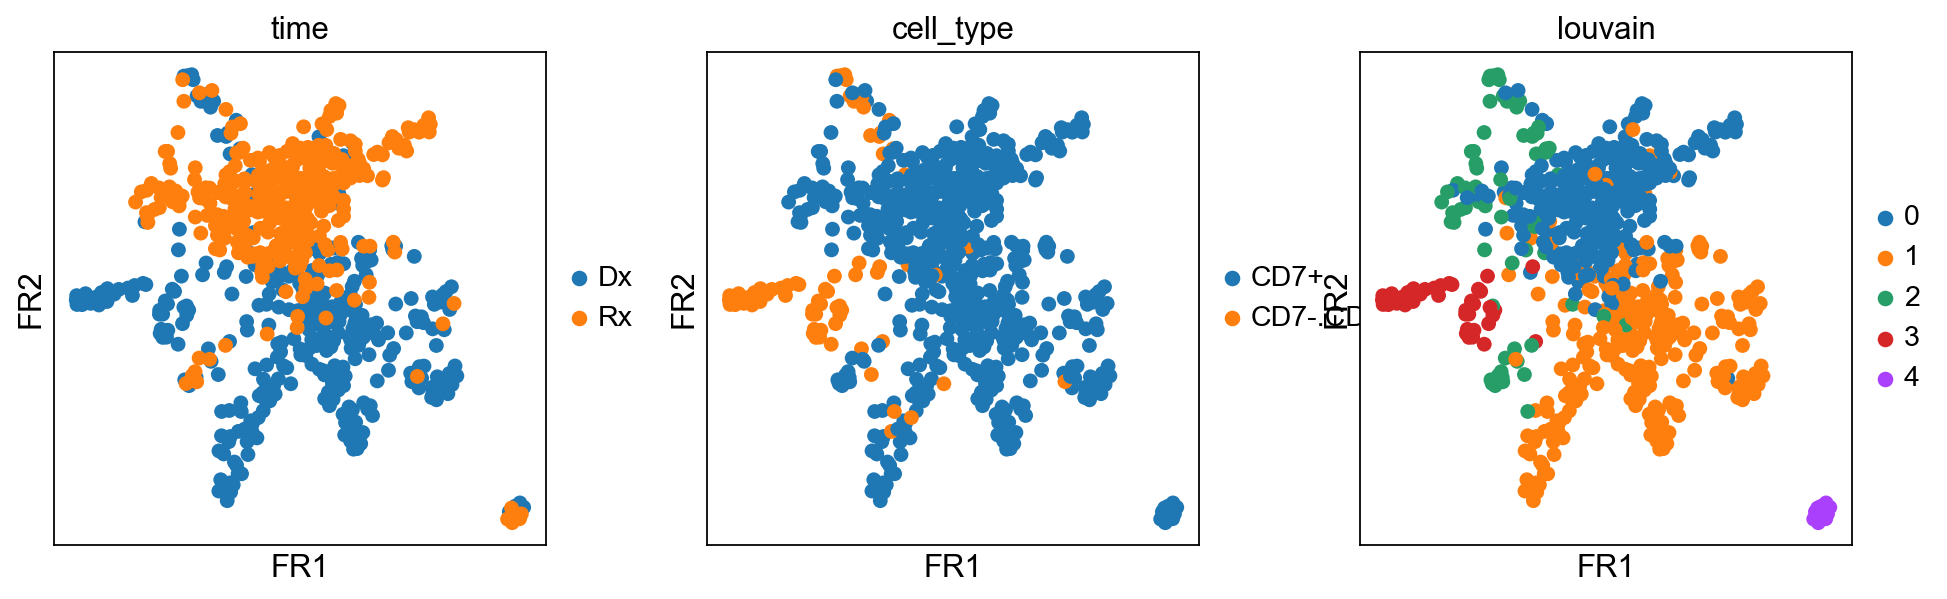

In [430]:
sc.pl.draw_graph(adata_Dx_Rx, color=['time','cell_type','louvain'])

In [431]:
sc.tl.paga(adata_Dx_Rx, groups='louvain')

running PAGA
    finished (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


/Users/yolanda_guillen/miniconda3/lib/python3.7/site-packages/anndata/core/anndata.py:299: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


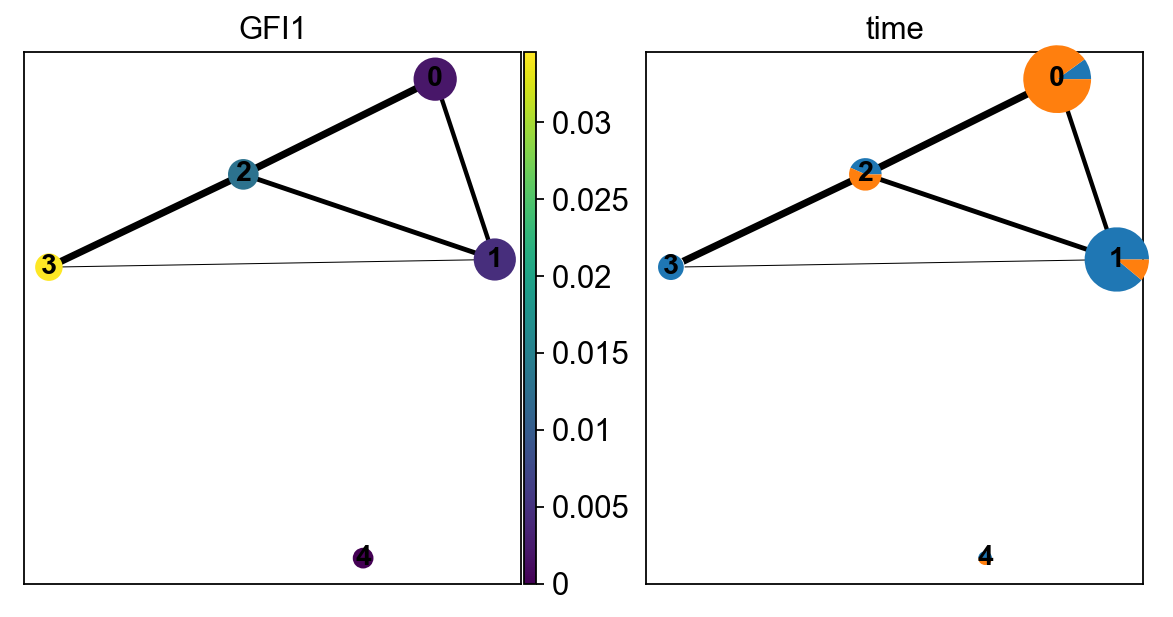

In [432]:
sc.pl.paga(adata_Dx_Rx,color=['GFI1','time'])

### Finding differentially expressed marker genes among clusters

ranking genes
    finished (0:00:00)


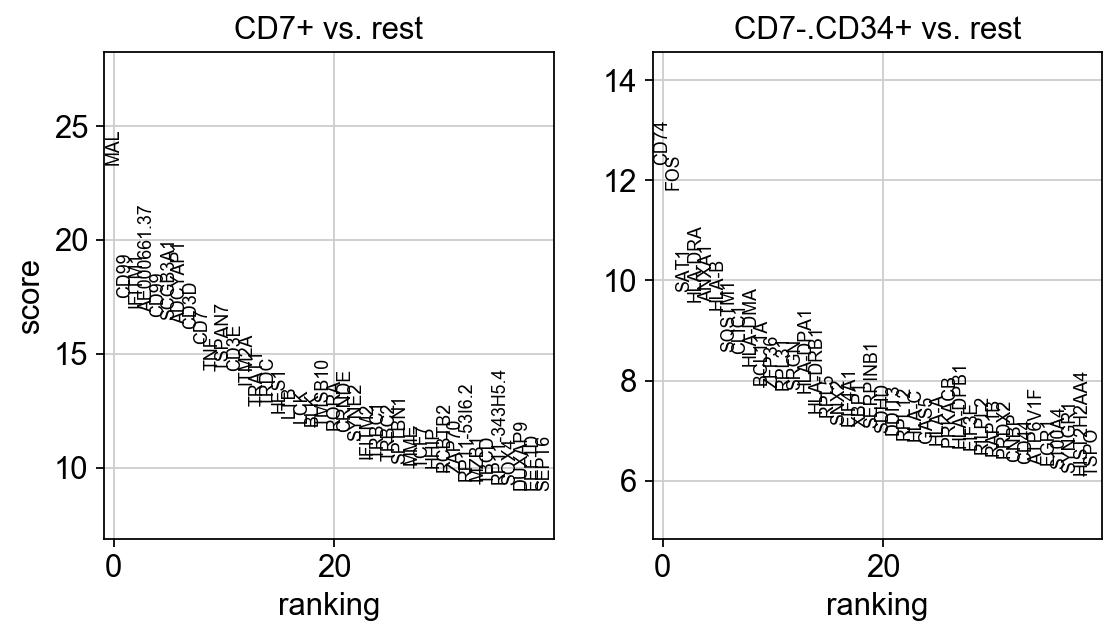

In [435]:

# Let us compute a ranking for the highly differential genes in each cluster. 
#For this, by default, the .raw attribute of AnnData is used in case it has been initialized before. 
# The simplest and fastest method to do so is the t-test.
#sc.tl.rank_genes_groups(adata, 'test_res1', method='t-test')
sc.tl.rank_genes_groups(adata_Dx_Rx, 'cell_type', method='t-test')
sc.pl.rank_genes_groups(adata_Dx_Rx, n_genes=40, sharey=False)


ranking genes
    finished (0:00:00)


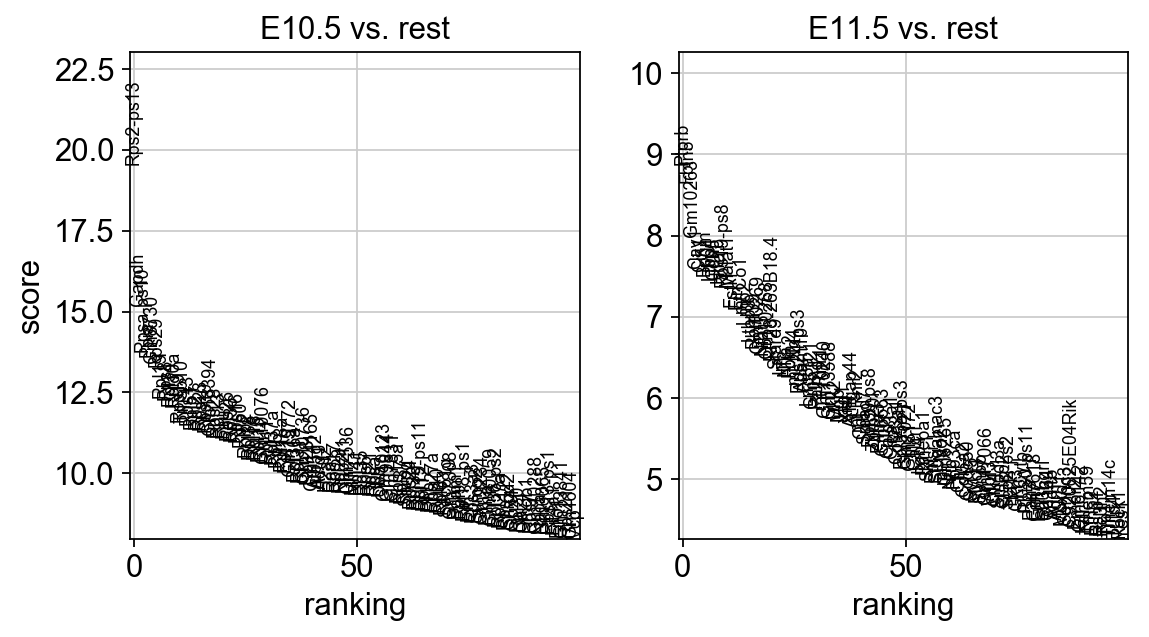

In [126]:
sc.tl.rank_genes_groups(k3, 'Time', method='t-test')
sc.pl.rank_genes_groups(k3, n_genes=100, sharey=False)

ranking genes
    finished (0:00:00)


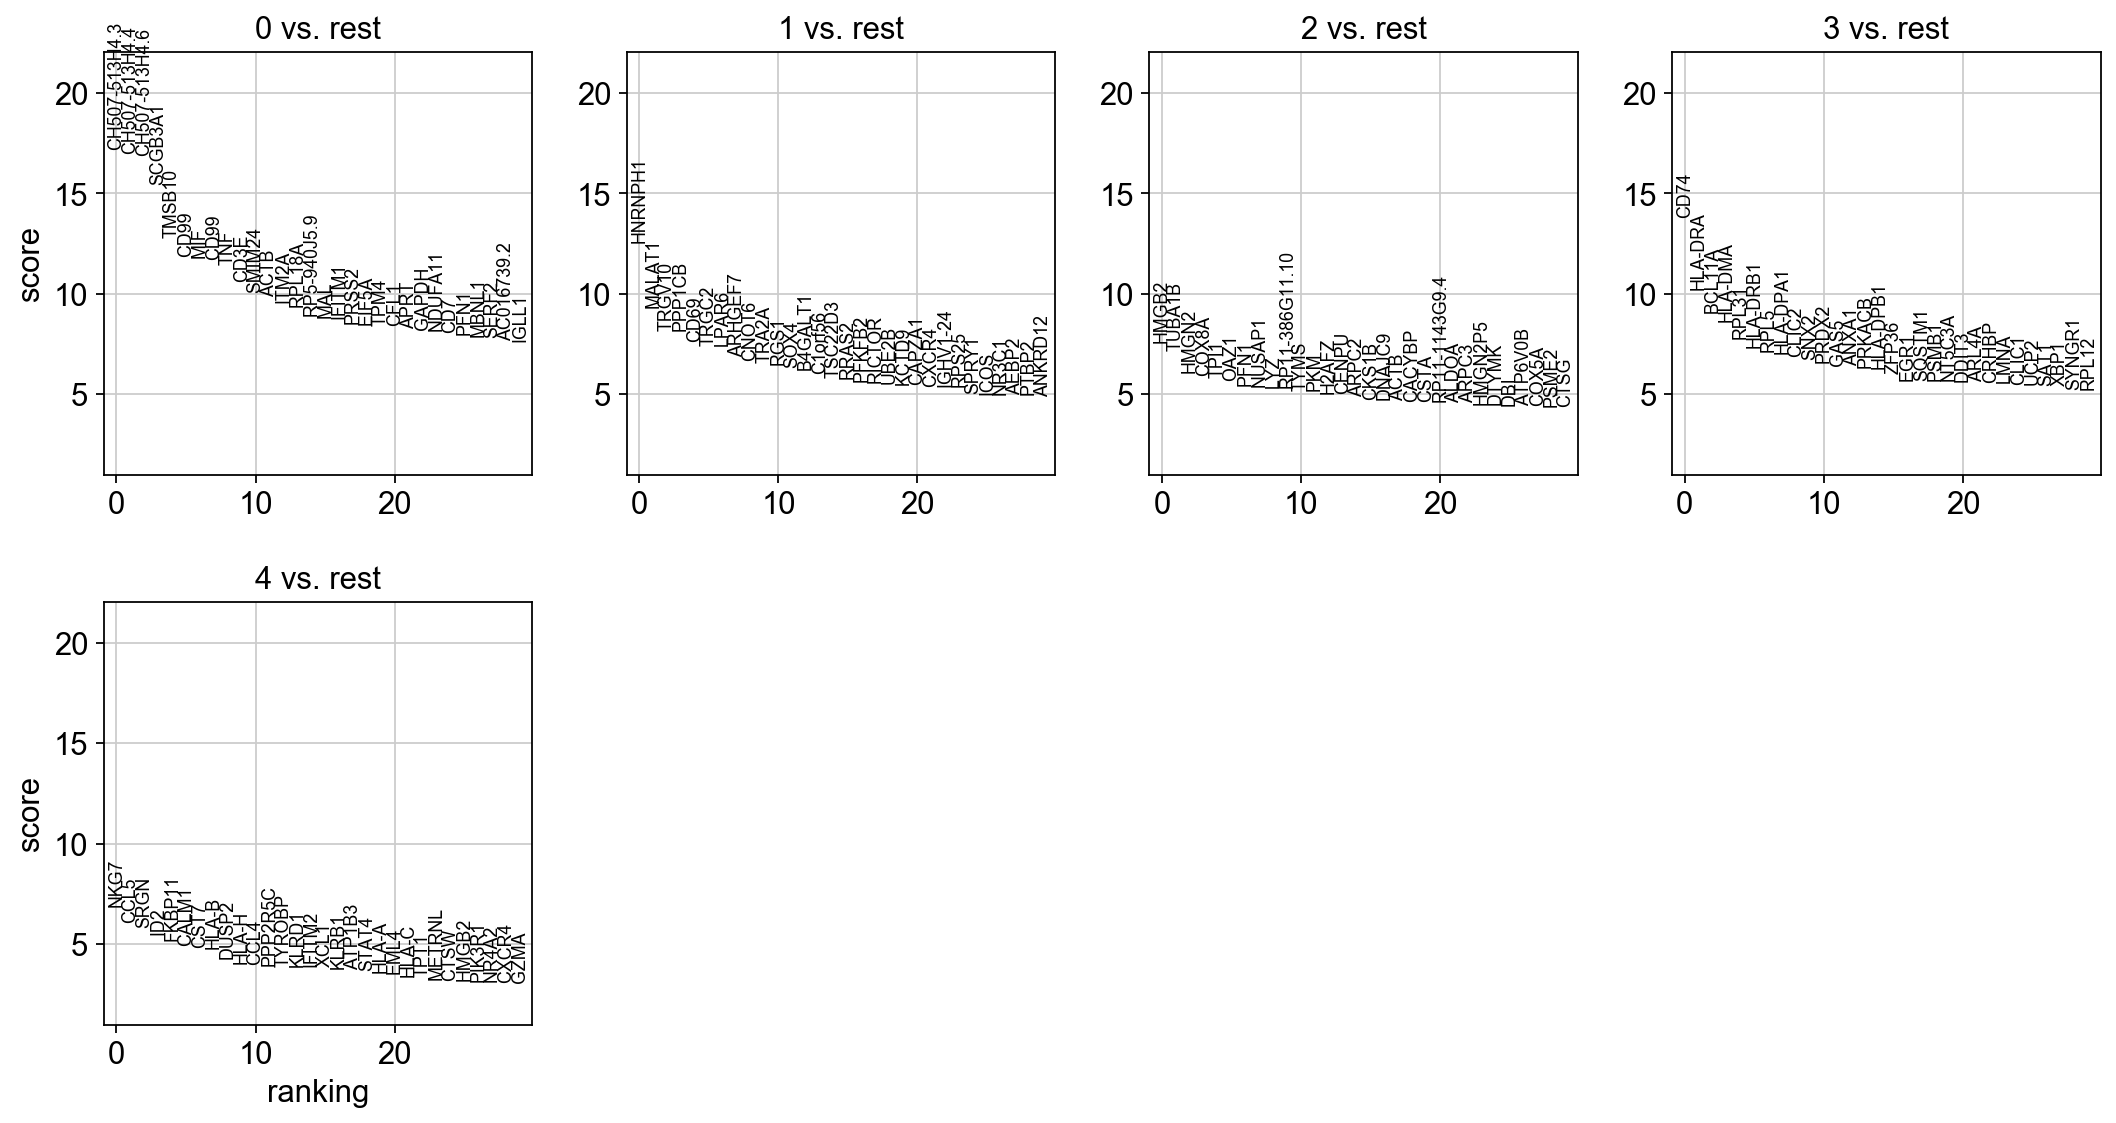

In [436]:
# The result of a Wilcoxon rank-sum (Mann-Whitney-U) test is very similar. 
# We recommend using the latter in publications, see e.g., Sonison & Robinson (2018). 
# You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, 
# for python, the recent diffxpy.

sc.tl.rank_genes_groups(adata_Dx_Rx, 'louvain','wilcoxon',n_genes=500)
sc.pl.rank_genes_groups(adata_Dx_Rx, n_genes=30,sharey=True)

In [ ]:
# Saving the results
adata.write(results_file)

In [437]:
# Create a dataframe with DEGs comparison among clusters
adata_Dx_Rx.uns['rank_genes_groups']

{'params': {'groupby': 'louvain',
  'reference': 'rest',
  'method': 't-test_overestim_var',
  'use_raw': 'wilcoxon',
  'corr_method': 'benjamini-hochberg'},
 'scores': rec.array([(17.195677 , 12.539119 , 7.5790887, 13.819342 , 6.8698254 ),
            (16.980637 ,  9.303937 , 7.2042527, 10.201823 , 6.0940084 ),
            (16.880901 ,  8.189372 , 6.110077 ,  9.094971 , 5.8230686 ),
            (15.450414 ,  8.158449 , 5.9380574,  8.604901 , 5.5012746 ),
            (12.81441  ,  7.6470847, 5.8366003,  7.7943363, 5.166608  ),
            (11.852964 ,  7.436609 , 5.68692  ,  7.321027 , 4.917889  ),
            (11.814888 ,  7.4153047, 5.4546103,  7.1121726, 4.848988  ),
            (11.725481 ,  6.881676 , 5.385653 ,  7.0498962, 4.8021708 ),
            (11.471938 ,  6.697564 , 5.3644896,  6.8680863, 4.273922  ),
            (10.607279 ,  6.5875754, 5.359788 ,  6.744724 , 4.0426946 ),
            (10.050957 ,  6.4936013, 5.206377 ,  6.593236 , 4.002262  ),
            ( 9.885834 ,  6.3

In [439]:
# To save raw data counts, and then export it
import anndata
adata_Dx_Rx_copy = anndata.AnnData(X=adata_Dx_Rx.raw.X, 
                                obs=adata_Dx_Rx.obs, 
                                obsm=adata_Dx_Rx.obsm,
                                uns=adata_Dx_Rx.uns,
                                var=adata_Dx_Rx.raw.var)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [440]:
# Export results (raw data counts). If scaled values, use adata instead of adata_copy
sc.external.exporting.cellbrowser(adata_Dx_Rx_copy,data_dir='/Users/yolanda_guillen/Desktop/IMIM/bigas_collab_scDx_Rel/TALL_bcat_project/cell_browser',data_name='adata_Dx_Rx')

INFO:root:Writing scanpy matrix (674 cells, 16366 genes) to /Users/yolanda_guillen/Desktop/IMIM/bigas_collab_scDx_Rel/TALL_bcat_project/cell_browser/exprMatrix.tsv.gz
INFO:root:Transposing matrix
INFO:root:Writing gene-by-gene, without using pandas
INFO:root:Writing 16366 genes in total
INFO:root:Wrote 0 genes
INFO:root:Wrote 2000 genes
INFO:root:Wrote 4000 genes
INFO:root:Wrote 6000 genes
INFO:root:Wrote 8000 genes
INFO:root:Wrote 10000 genes
INFO:root:Wrote 12000 genes
INFO:root:Wrote 14000 genes
INFO:root:Wrote 16000 genes
INFO:root:Writing Fruchterman Reingold coords to /Users/yolanda_guillen/Desktop/IMIM/bigas_collab_scDx_Rel/TALL_bcat_project/cell_browser/fr_coords.tsv
INFO:root:Writing UMAP coords to /Users/yolanda_guillen/Desktop/IMIM/bigas_collab_scDx_Rel/TALL_bcat_project/cell_browser/umap_coords.tsv
INFO:root:Writing /Users/yolanda_guillen/Desktop/IMIM/bigas_collab_scDx_Rel/TALL_bcat_project/cell_browser/markers.tsv
INFO:root:Generating /Users/yolanda_guillen/Desktop/IMIM/bi

### DEGs between cluster 4 vs. others

In [ ]:

sc.pl.rank_genes_groups_violin(adatared, groups='4', n_genes=20)


In [ ]:
sc.pl.violin(adatared, ['Notch2', 'Kit', 'Gfi1b','Efnb2','Ephb4'], groupby='louvain')
sc.pl.violin(adatared, ['Adgrg1','Procr','Gata2','Cd27'], groupby='louvain')

#### Proportion of cells expressing markers genes in each cluster

In [ ]:
marker_genes = ['Notch2','Notch1','Dll4','Kit', 'Gfi1b','Adgrg1','Procr','Gata2','Cd27']
ax = sc.pl.dotplot(adatared, marker_genes,groupby='louvain')